# Header

In [31]:
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
import joblib
from IPython.display import display
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from featexp import get_univariate_plots, get_trend_stats
import shap
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import xgbfir
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def predict_shap_sk(clf, X):
    iter_ = clf.best_iteration
    X_dm = xgb.DMatrix(X)
    preds = clf.get_booster().predict(X_dm, ntree_limit = iter_, pred_contribs=True)
    del X_dm; gc.collect()
    return preds

In [89]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!ls '../data/'

hist_EURIBOR_2008.xls hist_EURIBOR_2009.xls hist_EURIBOR_2010.xls


In [510]:
data = pd.read_csv('../data/raw/Bank_data.csv')

# Data description 

In [4]:
!cat ../data/raw/bank-names.txt



























21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

***

# EDA

The data is the dataset from UCI Machine learning repository with a few slight changes: a sample of 40000 out of ~41000 rows is taken and the column "duration" (which leaks target variable is removed). The dataset contains data from telemarketing calls with an offer to open a term deopsit from 2008 to 2010. **The data is ordered by date.**

As we can see from description there are 4 groups of features: 
* client data
* current campaign data
* previous campaigns data
* social and economic context


## Dataset timeline exploration

As it was mentioned earlier the dataset is ordered by time and target variable we track is time dependent. This means that we can't perform a random split and we need to perform a time-based validation. That also means that we need to analyze the dataset timeline in order to: 
1. Understand the behaviour of population over time 
2. Choose right time based split on the basis of this analysis

In order to visualize timeline variables better, week and month names can be converted into numeric values. This is done in notebook ***procces_data.ipynb*** and the result is used here. 

In [2]:
data_processed = pd.read_pickle('../data/processed/X')
data_processed['y'] = pd.read_pickle('../data/processed/y')

So we have an ordered dataset, with column *id* being an index of that order. Let's check that the data is really ordered

In [9]:
data_processed.head()

id  age  job  marital  education  default  housing  loan  contact  month  \
0   1   56    0        0          0        0        0     0        0      5   
1   2   57    1        0          1        1        0     0        0      5   
2   3   37    1        0          1        0        1     0        0      5   
3   4   40    2        0          2        0        0     0        0      5   
4   5   56    1        0          1        0        0     1        0      5   

   day_of_week  pdays  previous  poutcome  emp.var.rate  cons.price.idx  \
0            0    999         0         0           1.1          93.994   
1            0    999         0         0           1.1          93.994   
2            0    999         0         0           1.1          93.994   
3            0    999         0         0           1.1          93.994   
4            0    999         0         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y  
0          -36.4      4.857       5191.0  0  
1          -36.4      4.857       5191.0  0  
2          -36.4      4.857       5191.0  0  
3          -36.4      4.857       5191.0  0  
4          -36.4      4.857       5191.0  0

### Month of year

We see that the data is cyclic in nature and we can assume that these 3 cycles are years 2008, 2009, 2010 as was given in description.

However we see that the number of samples for each year is not equal. We will explore it further

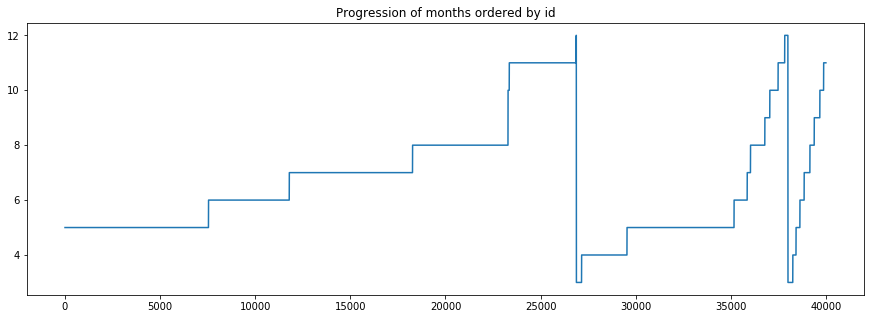

In [20]:
plt.figure(figsize=(15, 5))
plt.title("Progression of months ordered by id")
data_processed['month'].plot();

 Let's assign those years to a new variable.

In [23]:
data_processed['year'] = 2008
data_processed.loc[26879:38000, 'year'] = 2009
data_processed.loc[38001: , 'year'] = 2010

Let's make sure we got it all right

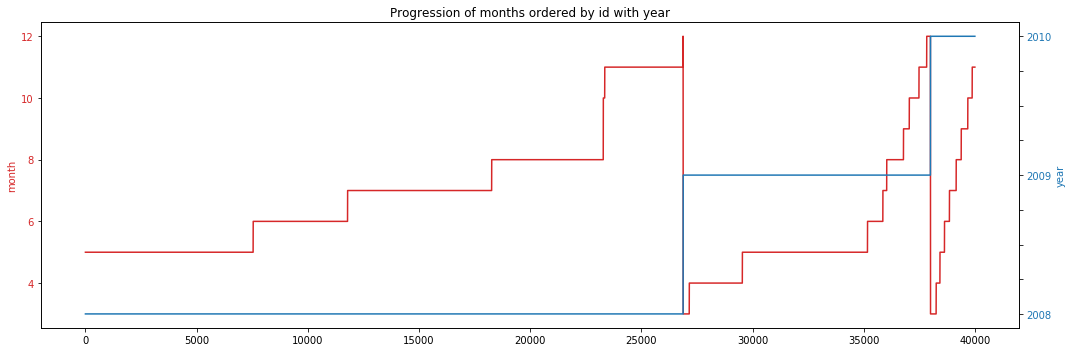

In [68]:
fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Progression of months ordered by id with year")
color = 'tab:red'
ax1.set_ylabel('month', color=color)
data_processed['month'].plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('year', color=color)  # we already handled the x-label with ax1
data_processed['year'].plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)
# labels = [item.get_text() for item in ax2.get_yticklabels()]
# new_labels = [ "%d" % int(float(l)) if '.00' in l else '' for l in labels]
ax2.set_yticklabels(['', '2008', '', '', '', '2009', '', '', '', '2010', ''])


fig.tight_layout() 


Let's now see which months are present in this dataset

In [326]:
print("Unique months", sorted(data_processed['month'].unique()) )

Unique months [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


First of all we notice, that there is no January and February in **any** year. Why is that so? I don't see any reasonable explanation for that. Ok, we start from May, 2008, but after that January and February are not present in next years, for no apparent reason. It seems like the data is at the very least badly collected and maybe even manipulated.

Let's see exactly, how samples are distributed over years

In [69]:
data_processed.year.value_counts()

2008    26879
2009    11122
2010     1999
Name: year, dtype: int64

In [72]:
data_processed.year.value_counts() / 40000

2008    0.671975
2009    0.278050
2010    0.049975
Name: year, dtype: float64

That doesn't look good, 67% of data is for 2008, 28% is for 2009, and only 5% is for 2010. That is given the fact that 2008 starts only with May, and subsequent years are covered fully (or should be, given the fact, that Jan and Feb are ommited). So 2009 and 2010 have more months but much fewer samples. 

Also let's not forget, that 2008 is abnormal year for banking services because of global financial crisis. And yet this the year with majority of data in train. I wouldn't rely to build a stable model for this task on the data from this period, yet the authors of the dataset for some reason do. 

I very much question the integrity of the data and the results of time-based validation, based on it. The rule "garbage-in-garbage-out" is very much true for this case, but I'll try to do my best to extract valueable information from it

Distribution by months is also very uneven for no apparent reason.

In [178]:
# Let's make a month timestamp as the first day of month
data_processed['year_month'] = data_processed.apply(lambda x: pd.Timestamp(year=int(x['year']),
                                                                           month=int(x['month']), day=1), axis=1)

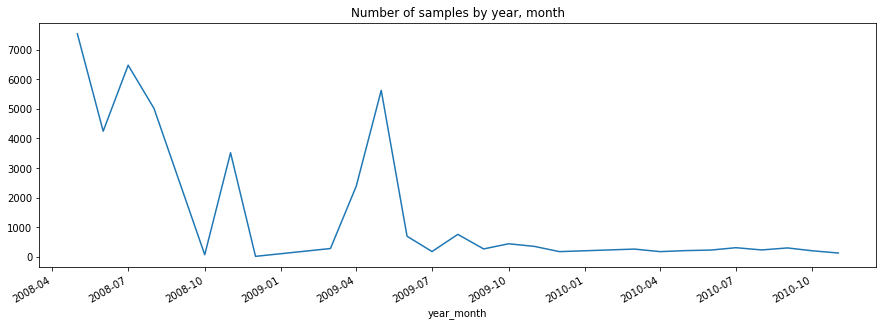

In [183]:
count_by_year_month = data_processed.groupby(['year_month']).year.count()
plt.figure(figsize=(15, 5))
plt.title("Number of samples by year, month")
count_by_year_month.plot();

In [191]:
count_by_year_month.tail()

year_month
2010-07-01    303
2010-08-01    227
2010-09-01    295
2010-10-01    198
2010-11-01    123
Name: year, dtype: int64

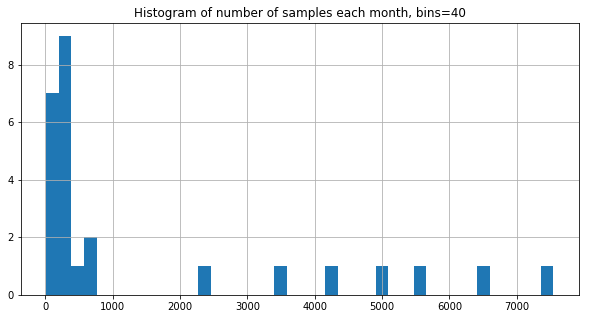

In [190]:
plt.figure(figsize=(10, 5))
plt.title("Histogram of number of samples each month, bins=40");
count_by_year_month.hist(bins=40);

In [189]:
print('Descriptive statistics of number of samples each month' )
display(count_by_year_month.describe())

Descriptive statistics of number of samples each month


count      26.000000
mean     1538.461538
std      2300.677296
min        10.000000
25%       199.500000
50%       285.000000
75%      1978.750000
max      7542.000000
Name: year, dtype: float64

🤦‍♂️

We've got 26 unique months. The minimum value of events per month is 10, the maximum is 7542, the **std is 2300**. That's a huge std and another sign that the dataset can't be trusted much

### Day of week

Weekdays are coded by integers from 0 to 6, 0 being Monday. Let's see how weekdays progress over time

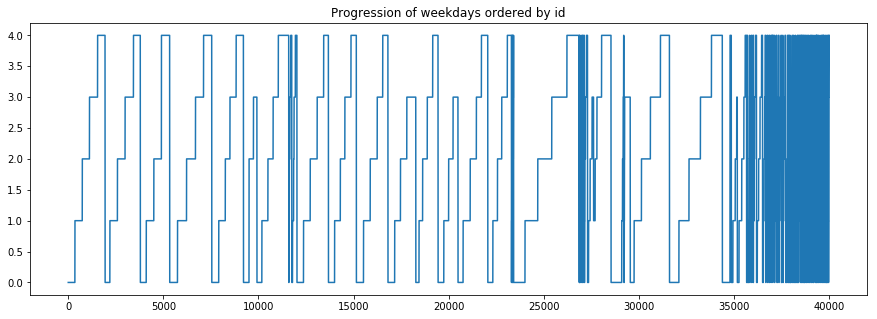

In [15]:
plt.figure(figsize=(15, 5))
plt.title("Progression of weekdays ordered by id")
data_processed.day_of_week.plot();

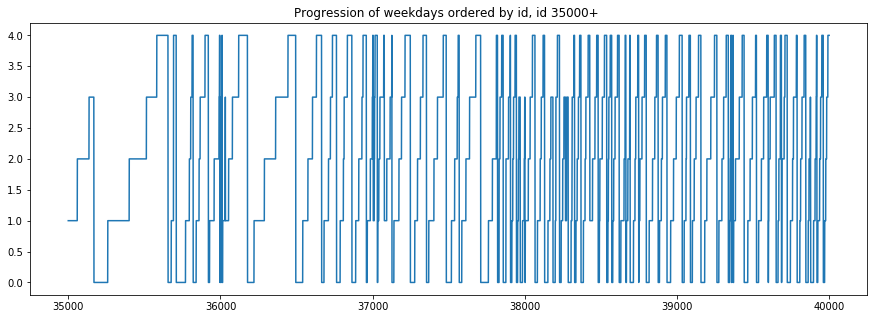

In [17]:
plt.figure(figsize=(15, 5))
plt.title("Progression of weekdays ordered by id, id 35000+ ")
data_processed.loc[35000:].day_of_week.plot();

This pattern, together with plots of months above confirms that the data is ordered by time. We see cyclic nature of weekdays progressing through time, and wee see that cycles become shorter by the end of the dataset, that's because we have much fewer samples in 2009 and 2010.

Let's see how samples are distributed over weekdays

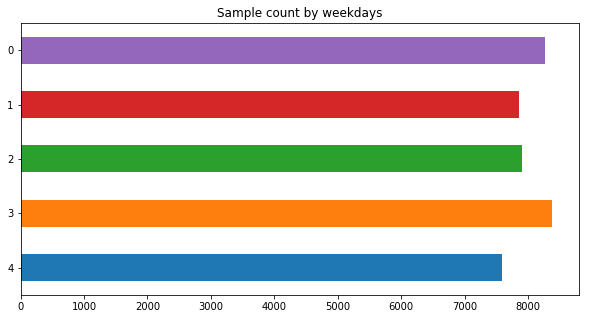

In [90]:
plt.figure(figsize=(10, 5))
plt.title("Sample count by day of week")
data_processed.day_of_week.value_counts().sort_index(ascending=False).plot(kind='barh',);

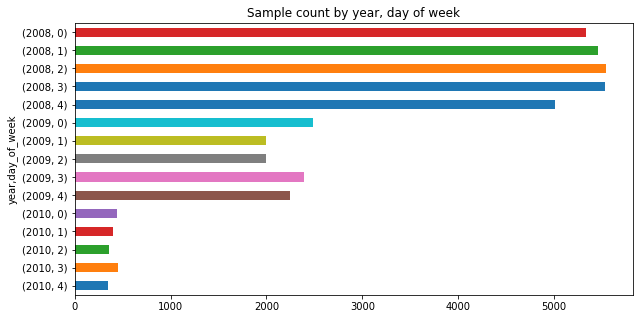

In [99]:
plt.figure(figsize=(10, 5))
plt.title("Sample count by year, day of week")
data_processed.groupby(['year', 'day_of_week']).year.count().sort_index(ascending=False).plot(kind='barh');

We see, that samples are distributed equally over weekdays, and only working days are present, which is normal for a bank telemarketing service making calls. 

### Overall target trend

Let's look at rolling mean of target, order by id

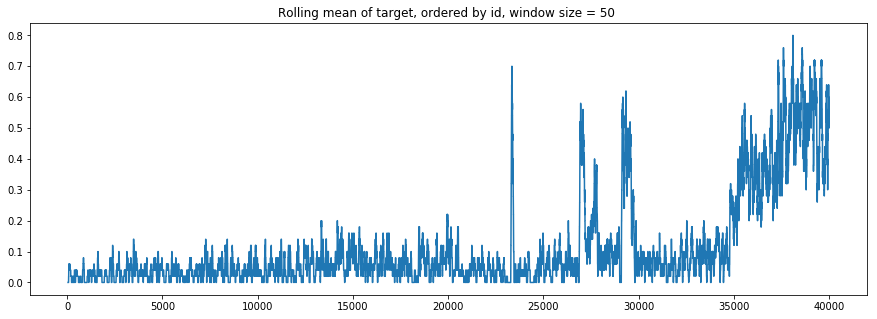

In [192]:
plt.figure(figsize=(15, 5))
plt.title("Rolling mean of target, ordered by id, window size = 50 ")
data_processed.rolling(50).y.mean().plot();

We see, that there are clear patterns of target dependence over time, and time variable by itself is a very important feature. Now given the facts observed above that years are distributed unequally in this dataset, this again raises questions about the integrity of the data, on whether realistic models can be built with such strange dataset.

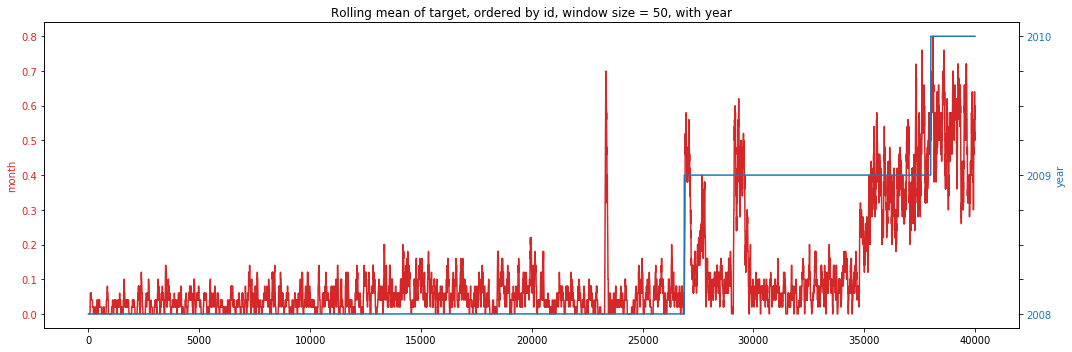

In [193]:
fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Rolling mean of target, ordered by id, window size = 50, with year")
color = 'tab:red'
ax1.set_ylabel('month', color=color)
data_processed.rolling(50).y.mean().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('year', color=color)  # we already handled the x-label with ax1
data_processed['year'].plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)
# labels = [item.get_text() for item in ax2.get_yticklabels()]
# new_labels = [ "%d" % int(float(l)) if '.00' in l else '' for l in labels]
ax2.set_yticklabels(['', '2008', '', '', '', '2009', '', '', '', '2010', ''])


fig.tight_layout() 


We see almost zero target in 2008, then a spike to ~0.3 a the start of 2009, another spike to 0.4, and year 2010 is 0.5. 
So time is very predictive feature for this dataset, but our validation is time-based and that is the problem. We have to find features which cause this time-based change on target. 

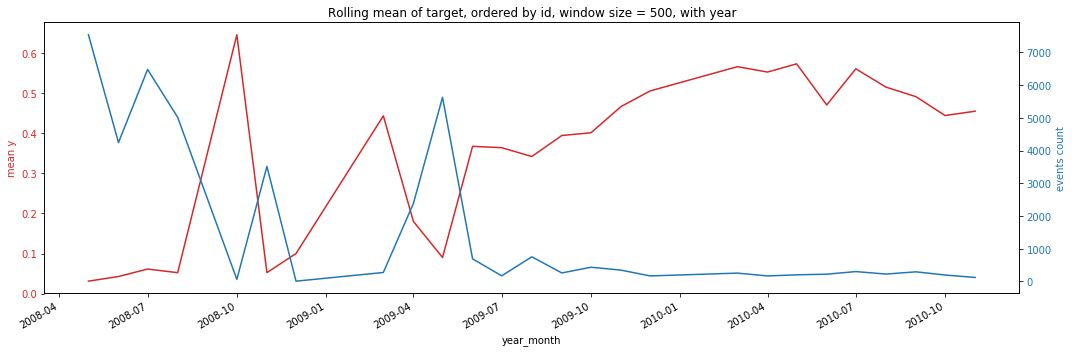

In [166]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Rolling mean of target, ordered by id, window size = 500, with year")
color = 'tab:red'
ax1.set_ylabel('mean y', color=color)
data_processed.groupby([ 'year_month',],).y.mean().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('events count', color=color)  # we already handled the x-label with ax1
data_processed.groupby([ 'year_month',],).y.count().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


In 2008, 2009 we see, that the more events there in month, the smaller mean target is, in 2010 there are much fewer events compared to previous years, but much higher mean target. Our model could overfit to time, and if we omit time features to proxy features that represent time(euribor3m, for example), but target change is not caused by feature itself, but by the fact, that it's a proxy of time 

Uneven number of samples for each month, small number of samples along with high target are signs of not a very qualited dataset. 

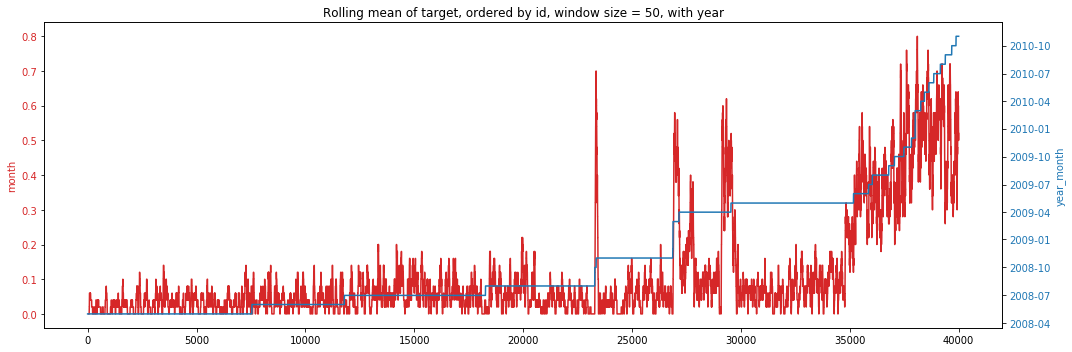

In [168]:
fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Rolling mean of target, ordered by id, window size = 50, with year")
color = 'tab:red'
ax1.set_ylabel('month', color=color)
data_processed.rolling(50).y.mean().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('year_month', color=color)  # we already handled the x-label with ax1
data_processed['year_month'].plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)
# labels = [item.get_text() for item in ax2.get_yticklabels()]
# new_labels = [ "%d" % int(float(l)) if '.00' in l else '' for l in labels]
# ax2.set_yticklabels(['', '2008', '', '', '', '2009', '', '', '', '2010', ''])


fig.tight_layout() 


### Identifying days

First of all let's a unique day id. Our dataset is ordered by time and we have day of week, month and year. We create a new column with month and day, and increment a counter each time it changes in ordered dataset. 

In [3]:
data_processed['mon_dow'] = data_processed.apply(lambda x: '%s_%s' % (int(x.month), int(x.day_of_week)), axis=1 )

data_processed['mon_dow_p'] = data_processed['mon_dow'].shift()

data_processed['day_id'] = (data_processed.mon_dow != data_processed['mon_dow_p']).cumsum() - 1

In [4]:
pd.set_option('display.max_rows', 500)

In [5]:
data_processed[['id', 'month', 'day_of_week', 'day_id']].loc[346:350]

id  month  day_of_week  day_id
346  347      5            0       0
347  348      5            0       0
348  349      5            0       0
349  350      5            1       1
350  351      5            1       1

In [6]:
data_processed[[ 'id',  'month', 'day_of_week', 'day_id']].loc[734:737]

id  month  day_of_week  day_id
734  735      5            1       1
735  736      5            1       1
736  737      5            2       2
737  738      5            2       2

In [7]:
data_processed[[ 'id',  'month', 'day_of_week', 'day_id']].tail(20)

id  month  day_of_week  day_id
39980  39981     11            2     485
39981  39982     11            2     485
39982  39983     11            2     485
39983  39984     11            3     486
39984  39985     11            3     486
39985  39986     11            3     486
39986  39987     11            3     486
39987  39988     11            3     486
39988  39989     11            3     486
39989  39990     11            3     486
39990  39991     11            3     486
39991  39992     11            4     487
39992  39993     11            4     487
39993  39994     11            4     487
39994  39995     11            4     487
39995  39996     11            4     487
39996  39997     11            4     487
39997  39998     11            4     487
39998  39999     11            4     487
39999  40000     11            4     487

Looks good. Every time month and day of week changes, day id incerements. 

In [8]:
print("We have %s unique days" % data_processed.day_id.nunique())

We have 488 unique days


In [9]:
events_ct_by_day = data_processed.groupby([ 'day_id',],).y.count()

We calculate events count by day and see abnormal spikes of days with high event count 

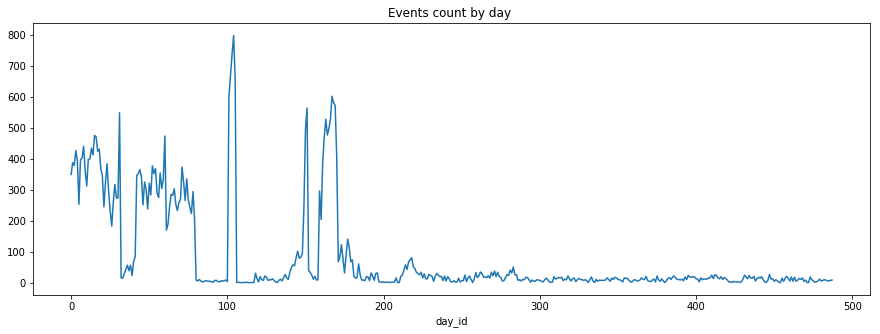

In [241]:
plt.figure(figsize=(15, 5))
plt.title("Events count by day ")
events_ct_by_day.plot();

In [245]:
print('Unique days per year')
display(data_processed.groupby([ 'year',],).day_id.nunique())

Unique days per year


year
2008    118
2009    190
2010    180
Name: day_id, dtype: int64

We also have spikes in mean y.

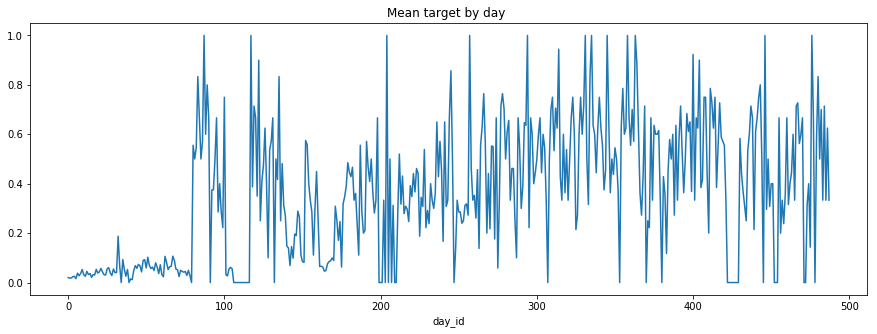

In [260]:
plt.figure(figsize=(15, 5))
plt.title("Events count by day ")
data_processed.groupby([ 'day_id',],).y.mean().plot();


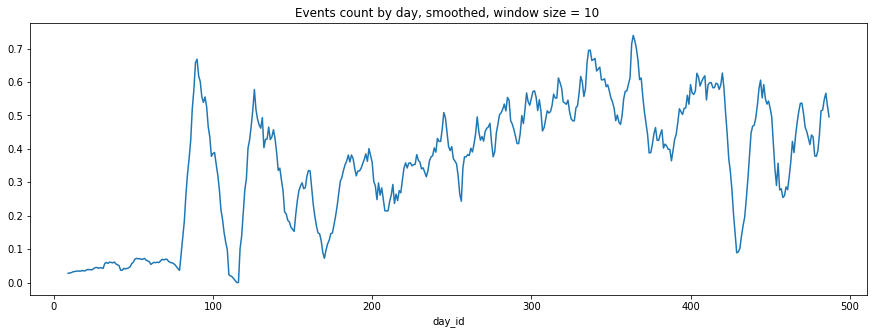

In [261]:
plt.figure(figsize=(15, 5))
plt.title("Events count by day, smoothed, window size = 10 ")
data_processed.groupby([ 'day_id',],).y.mean().rolling(10).mean().dropna().plot()


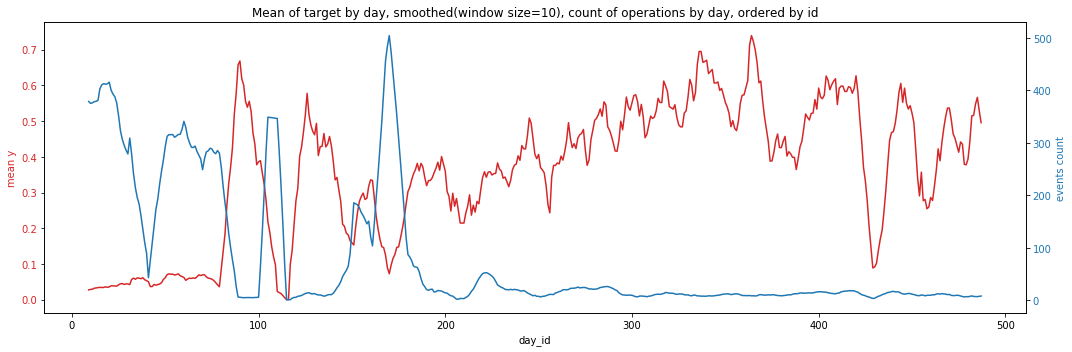

In [262]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Mean of target by day, smoothed(window size=10), count of operations by day, ordered by id")
color = 'tab:red'
ax1.set_ylabel('mean y', color=color)
data_processed.groupby([ 'day_id',],).y.mean().rolling(10).mean().dropna().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('events count', color=color)  # we already handled the x-label with ax1
data_processed.groupby([ 'day_id',],).y.count().rolling(10).mean().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


The less events there are, the bigger is the mean target per day

### Get dates via euribor3m

Given the fact, that we have euribor3m in our dataset, month, year and day of week, we can identify the exact date of each sample in the dataset. The euribor data was taken from https://www.emmi-benchmarks.eu/euribor-org/euribor-rates.html 

In [10]:
# reading and processing euribor data
eur_2008 = pd.read_excel('../data/raw/hist_EURIBOR_2008.xls')
eur_2009 = pd.read_excel('../data/raw/hist_EURIBOR_2009.xls')
eur_2010 = pd.read_excel('../data/raw/hist_EURIBOR_2010.xls')

eur_2008 = eur_2008.loc['3m'].to_frame()
eur_2009 = eur_2009.loc['3m'].to_frame()
eur_2010 = eur_2010.loc['3m'].to_frame()

eur_2010.index = eur_2010.index.to_series().apply(lambda x: pd.Timestamp(datetime.strptime(x, '%d/%m/%Y') ) )
eur_all = pd.concat([eur_2008,  eur_2009, eur_2010])
eur_all.reset_index(inplace=True)

In [11]:
eur_all.columns = ['DATE', 'EUR_3M']

In [12]:
eur_all.set_index('DATE', drop=False, inplace=True)

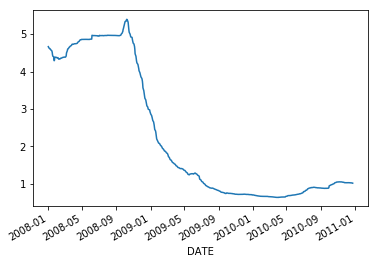

In [13]:
eur_all['EUR_3M'].plot()

In [14]:
eur_all['dow'] = eur_all.DATE.dt.dayofweek

In [15]:
eur_all['mon'] = eur_all.DATE.dt.month

In [16]:
eur_all['year'] = eur_all.DATE.dt.year

In [17]:
eur_ct = eur_all.groupby(['EUR_3M', 'dow', 'mon', 'year']).DATE.count().sort_values(ascending=False)

In [18]:
eur_ct[eur_ct > 1].head()

EUR_3M  dow  mon  year
4.857   0    5    2008    3
0.661   0    2    2010    3
4.961   1    7    2008    3
4.860   3    5    2008    2
0.879   4    9    2010    2
Name: DATE, dtype: int64

In [19]:
print('%s euribor3m values have repeated day of week, month, year' %  eur_ct[eur_ct > 1].shape[0] ) 

29 euribor3m values have repeated day of week, month, year


For the given period of data we see, that there are some repetead values for given day of week, month and year, but given the fact, that our data is sorted by time, we can get the right day looking at previous day given the fact that it's not ambiguous. By doing so iteratively we can define all days 

In [20]:
eur_gr_by_eur = eur_all.groupby(['EUR_3M', 'dow', 'mon', 'year']).apply(lambda x:  pd.Series({'DATES': x.DATE.tolist()}) ).reset_index()


In [24]:
data_processed.euribor3m = data_processed.euribor3m.round(3)

eur_gr_by_eur.EUR_3M = eur_gr_by_eur.EUR_3M.round(3)

data_processed_m = data_processed.merge(eur_gr_by_eur, left_on=['euribor3m', 'day_of_week', 'month', 'year'], right_on = ['EUR_3M', 'dow', 'mon', 'year'], how="inner")


In [25]:
print('%s out of %s samples matched euribor3m month, day of week, year' % (data_processed_m.shape[0], data_processed.shape[0]))

39998 out of 40000 samples matched euribor3m month, day of week, year


That gives us hint that data, which is present is likely to be legit in this aspect, although non-legitimely sampled. May be we should dismiss those 2 samples, which didn't match. There's no way euribor3m couldn't match those condition.

Let's eliminate ambiguous dates

In [26]:
data_processed_m['ct_events_day'] = data_processed_m.groupby('day_id').day_id.transform('count')

data_processed_m['mean_y_day'] = data_processed_m.groupby('day_id').y.transform('mean')

day_id_data = data_processed_m[['day_id', 'month', 'day_of_week', 'DATES', 'ct_events_day', 'mean_y_day', 'euribor3m']].drop_duplicates(subset='day_id')


In [27]:
day_id_data.rename(columns={'DATES': 'DATES_IT_0'}, inplace=True)

day_id_data = day_id_data.sort_values('day_id').reset_index(drop=True)

day_id_data['NEXT_DATES_IT_0'] = day_id_data.DATES_IT_0.shift(-1)

In [28]:
def choose_date(row, dates_col, next_dates_col):
    if row[next_dates_col] is np.nan:
        result = row[dates_col]
    elif len(row[next_dates_col]) != 1 or len(row[dates_col]) == 1 :
        result = row[dates_col]
    else:
        dates = pd.Series(row[dates_col])
        ddiff = (dates - row[next_dates_col][0]).apply(lambda x: abs (x.days))
        result = dates[(dates < row[next_dates_col][0]) & (ddiff < 7)].tolist()
    return result

In [32]:
all_chosen = False

n_step = 1 

while not all_chosen:
    print('Starting step %s ' % n_step)
    prev_step = n_step - 1
    day_id_data['DATES_IT_%s' % n_step] = day_id_data.apply(choose_date, axis=1, dates_col = 'DATES_IT_%s' % prev_step, 
                                                            next_dates_col='NEXT_DATES_IT_%s' % prev_step )
    day_id_data['NEXT_DATES_IT_%s' % n_step] = day_id_data['DATES_IT_%s' % n_step ].shift(-1)    
    max_len = day_id_data['DATES_IT_%s' % n_step ].apply(len).max()
    print('Max dates length %s ' % max_len)
    all_chosen = max_len == 1
    n_step += 1
    

Starting step 1 
Max dates length 3 
Starting step 2 
Max dates length 2 
Starting step 3 
Max dates length 2 
Starting step 4 
Max dates length 1 


The maximum length of ambiguos dates is 1, that means we eliminated all the alternatives. We have only on sample, where we have no potential dates

In [33]:
day_id_data[day_id_data['DATES_IT_4'].apply(len) == 0]

day_id  month          ...            DATES_IT_4        NEXT_DATES_IT_4
284     284     11          ...                    []  [2009-11-25 00:00:00]

[1 rows x 16 columns]

Let's see, why it's the case

In [34]:
day_id_data[day_id_data.day_id.between(283, 285)]

day_id          ...                  NEXT_DATES_IT_4
283     283          ...                               []
284     284          ...            [2009-11-25 00:00:00]
285     285          ...            [2009-11-27 00:00:00]

[3 rows x 16 columns]

In my algorithm I assumed, that there can't be a gap, more than a week long between days, but there was one. We can set this date manually

In [35]:
day_id_data['DATE'] = day_id_data.DATES_IT_4.apply(lambda x: x[0] if len(x) > 0 else x)

In [36]:
day_id_data.loc[284, 'DATE'] = pd.Timestamp(2009, 11, 17)

In [37]:
day_id_data_fin = day_id_data[['day_id', 'month', 'day_of_week',  'DATE', 'ct_events_day', 'mean_y_day', 'euribor3m']].set_index('DATE', drop=False)

We can now merge this result and use the discovered dates in our research

In [38]:
data_processed_time = data_processed.merge(day_id_data_fin.drop(['euribor3m', 'day_of_week', 'month'], axis=1), on='day_id' ).set_index('DATE', drop=False)


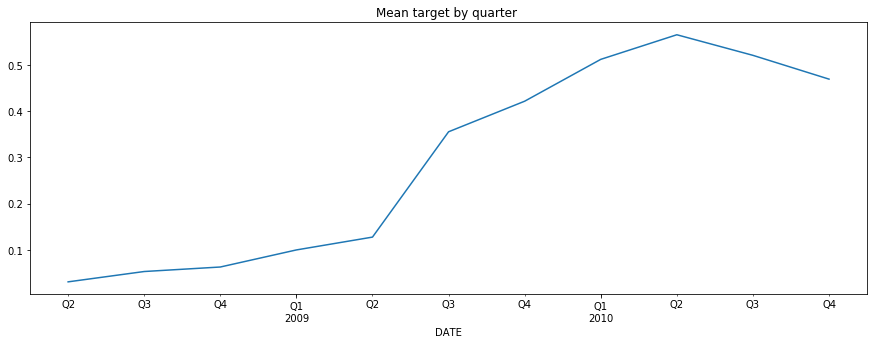

In [292]:
plt.figure(figsize=(15, 5))
plt.title("Mean target by quarter ")
data_processed_time.resample('3M').y.mean().dropna().plot()

In [39]:
data_processed_time.to_pickle('../data/processed/data_processed_time')

### Skipped days

Let's see how they days were skipped

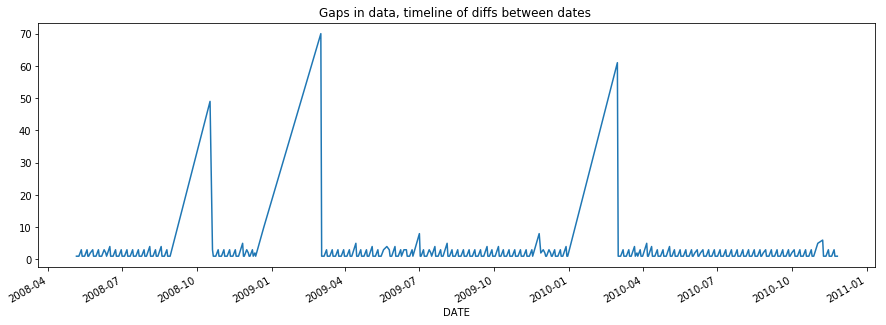

In [313]:
plt.figure(figsize=(15, 5))
plt.title("Gaps in data, timeline of diffs between dates ")
day_id_data_fin.DATE.diff().dt.days.plot()

We see a gap in data in autumn of 2008 and then mean target rises rapidly

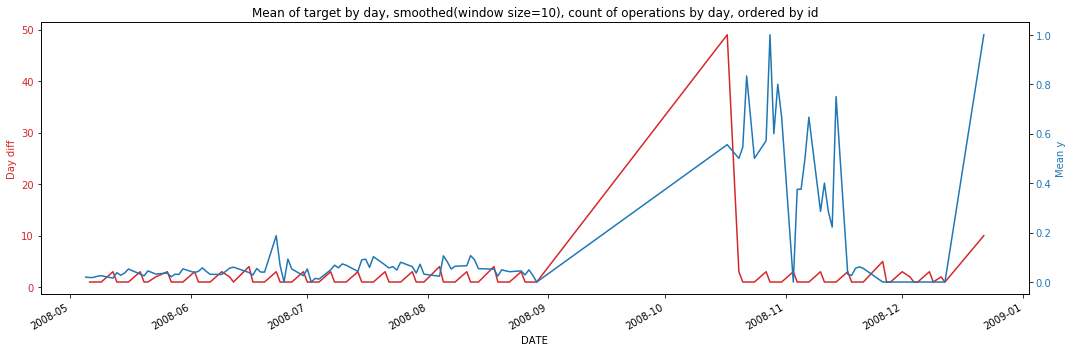

In [324]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Mean of target by day, smoothed(window size=10), count of operations by day, ordered by id")
color = 'tab:red'
ax1.set_ylabel('Day diff', color=color)
day_id_data_fin[day_id_data_fin.DATE.dt.year == 2008].DATE.diff().dt.days.plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Mean y', color=color)  # we already handled the x-label with ax1
data_processed_time[data_processed_time.year == 2008].groupby([ 'DATE',],).y.mean().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


No significant gaps in 2009, 2010

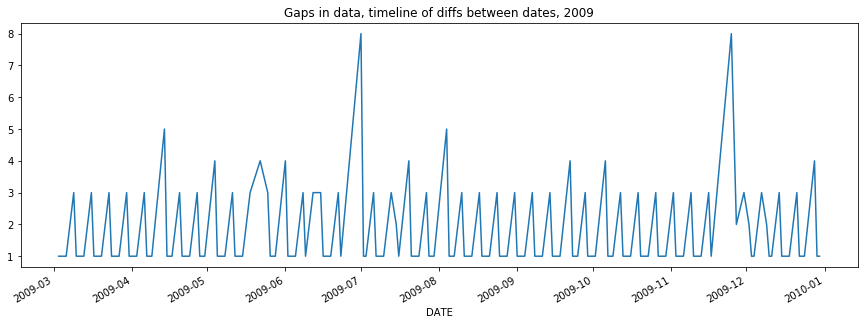

In [315]:
plt.figure(figsize=(15, 5))
plt.title("Gaps in data, timeline of diffs between dates, 2009")
day_id_data_fin[day_id_data_fin.DATE.dt.year == 2009].DATE.diff().dt.days.plot();

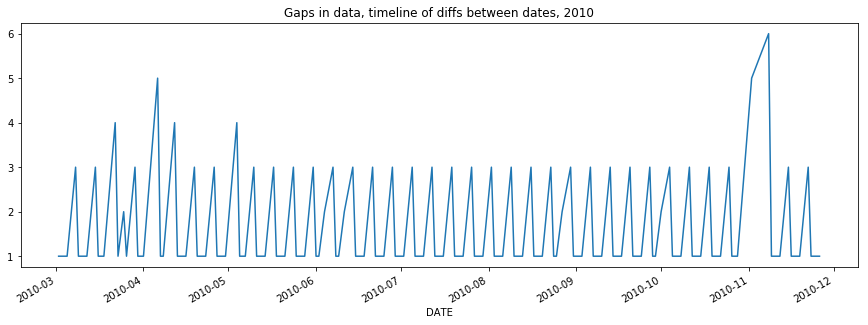

In [316]:
plt.figure(figsize=(15, 5))
plt.title("Gaps in data, timeline of diffs between dates, 2010")
day_id_data_fin[day_id_data_fin.DATE.dt.year == 2010].DATE.diff().dt.days.plot()

## Economic factors

### Euribor

This is one of the most important features for all models trained for this dataset.

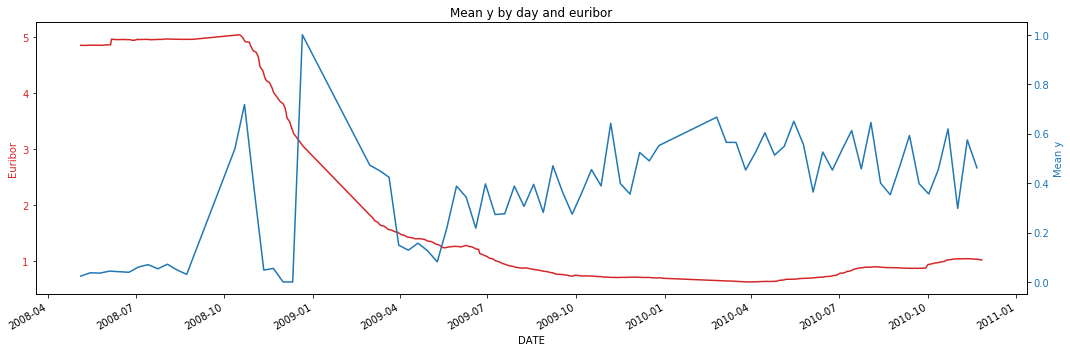

In [424]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Mean y by day and euribor")
color = 'tab:red'
ax1.set_ylabel('Euribor', color=color)
data_processed_time.resample('1D')['euribor3m'].mean().dropna().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Mean y', color=color)  # we already handled the x-label with ax1
data_processed_time.resample('10D')['y'].mean().dropna().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


We see that euribor3m decreases over time, mean target increases over time. We know in 2009, 2010 there are much fewer samples, and their mean target is much higher.  The rapid change of euribor3m is abnormal behaviour as a result of financial crisis. This period shouldn't be used as train to build a prediction model for a stable economic period

If we split euribor3m into equal bins and count mean target for the whole dataset, we would get the following.

In [362]:
data_processed_time['euribor3m_q10'] = pd.qcut(data_processed_time.euribor3m, 10) 

euribor_q10_target_trend = data_processed_time.groupby(['euribor3m_q10']).y.agg(['mean', 'count'])

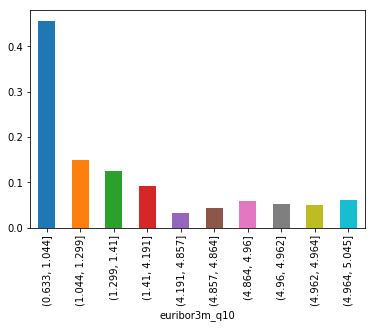

In [363]:
euribor_q10_target_trend['mean'].plot(kind='bar')

We see that the lower the bin, the higher the rate of agreeing to term deposit. That's a bit counter-intuitive. The lower the euribor, the lower the deposit rate. But lower euribor is just a proxy for time, and why does success rate increase, by time? Because the country is recovering from financial crisis. Again, if use this feature, we will overfit to training period

Suppose we train on 2008 in order to predict 2009. Let's see, what we'll have in train and in test

In [371]:
data_processed_time_2008 = data_processed_time[data_processed_time.year == 2008]

In [372]:
data_processed_time_2009 = data_processed_time[data_processed_time.year == 2009]

In [373]:
data_processed_time_2008.shape

(26879, 31)

In [374]:
data_processed_time_2009.shape

(11120, 31)

                                         Plots for euribor3m                                          
Only one bin created for euribor3m. Correlation can't be calculated
                                           Train data plots                                           


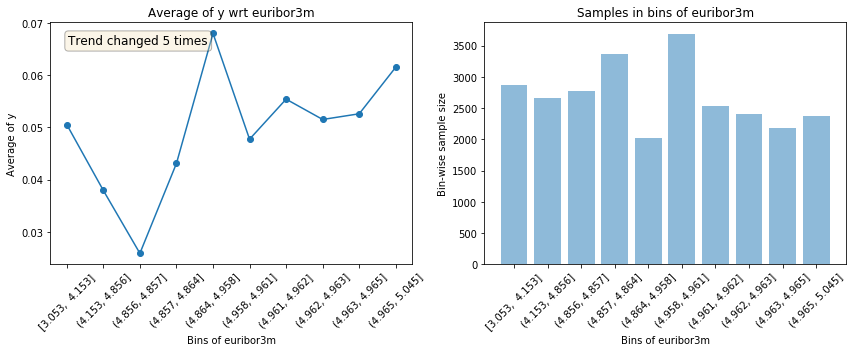

                                           Test data plots                                            


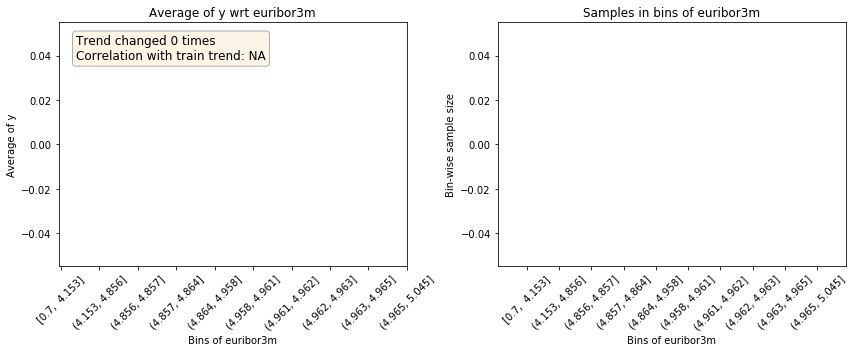

--------------------------------------------------------------------------------------------------------------




In [379]:
get_univariate_plots(data_processed_time_2008, 'y', ["euribor3m"], data_test=data_processed_time_2009)

We see that euribor3m for 2008 doesn't even within a range of 2009. So it will be an important feature on train, but the distribution of this feature on test is completely different, so we will overfit to this feautre. It should not be used. 

### Consumer price index

This feature overfits too

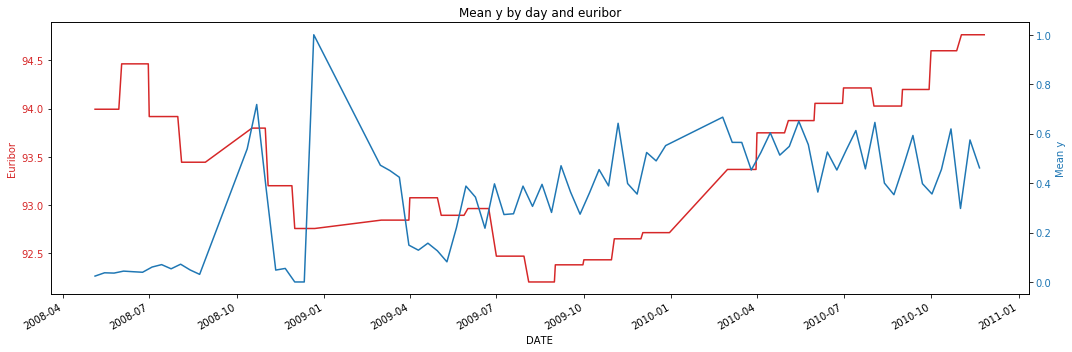

In [385]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Mean y by day and euribor")
color = 'tab:red'
ax1.set_ylabel('Euribor', color=color)
data_processed_time.resample('1D')['cons.price.idx'].mean().dropna().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Mean y', color=color)  # we already handled the x-label with ax1
data_processed_time.resample('10D')['y'].mean().dropna().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


                                       Plots for cons.price.idx                                       
Only one bin created for cons.price.idx. Correlation can't be calculated
                                           Train data plots                                           


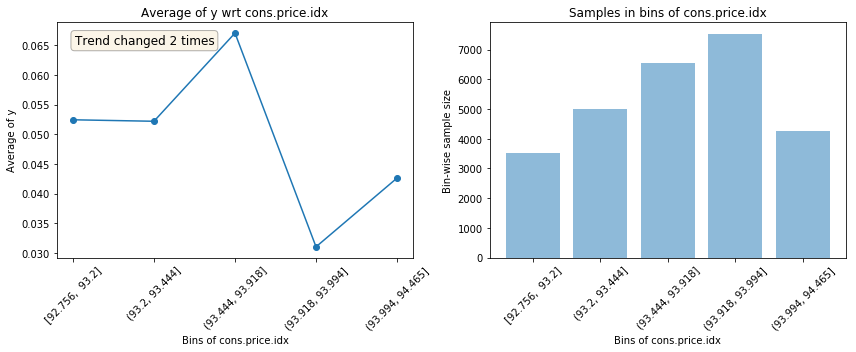

                                           Test data plots                                            


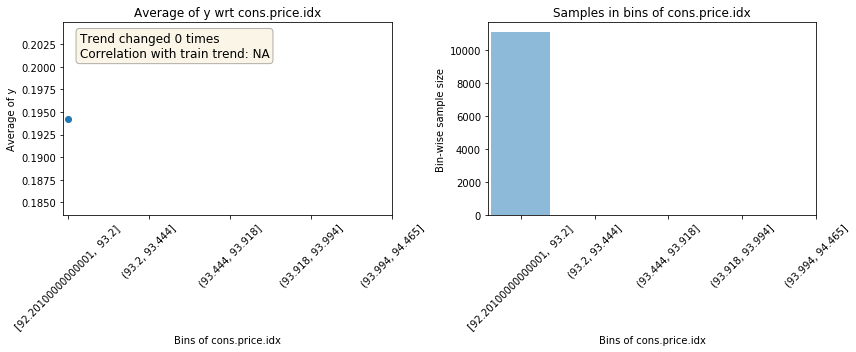

--------------------------------------------------------------------------------------------------------------




In [386]:
get_univariate_plots(data_processed_time_2008, 'y', ["cons.price.idx"], data_test=data_processed_time_2009)

## Client data

1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### Age

In [389]:
data_processed_time.age.describe()

count    39998.000000
mean        40.021551
std         10.410966
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

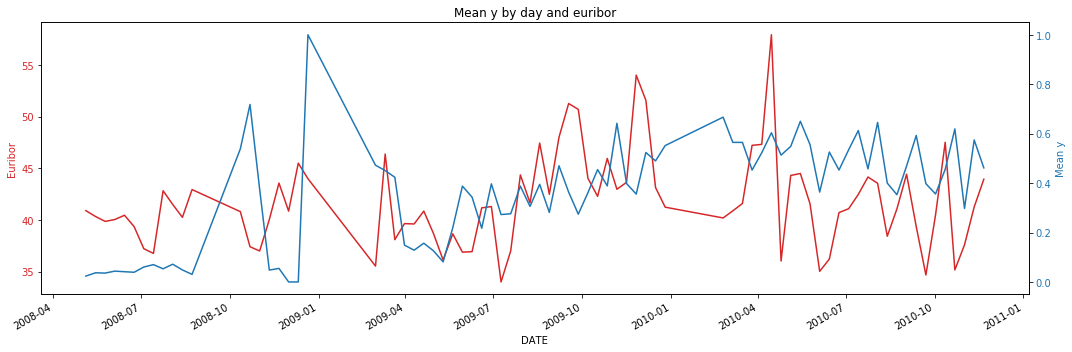

In [406]:

fig, ax1 = plt.subplots(figsize=(15, 5), )
# plt.figure(figsize=(15, 5))
ax1.set_title("Mean y by day and euribor")
color = 'tab:red'
ax1.set_ylabel('Euribor', color=color)
data_processed_time.resample('10D')['age'].mean().dropna().plot(ax=ax1, color=color);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Mean y', color=color)  # we already handled the x-label with ax1
data_processed_time.resample('10D').y.mean().dropna().plot(ax=ax2, color=color);

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 


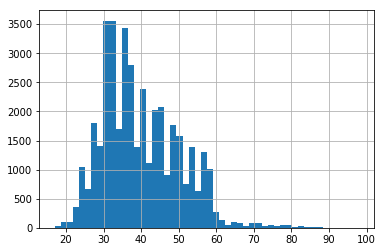

In [407]:
data_processed_time.age.hist(bins=50)

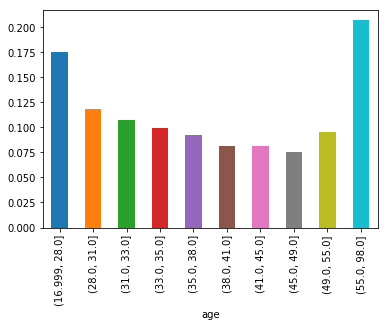

In [570]:
data_processed_time.groupby(pd.qcut(data_processed_time.age, 10)  ).y.mean().plot(kind='bar')

## Job

In [410]:
data_processed_time.job = data_processed_time.job.astype('category')

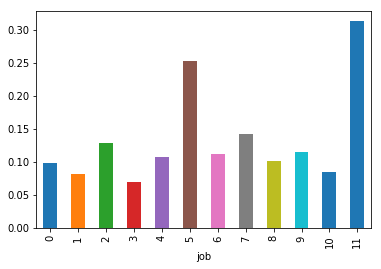

In [414]:
data_processed_time.groupby('job').y.mean().plot(kind='bar')

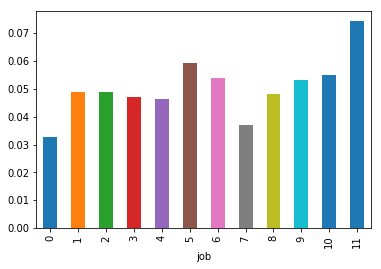

In [415]:
data_processed_time_2008.groupby('job').y.mean().plot(kind='bar')

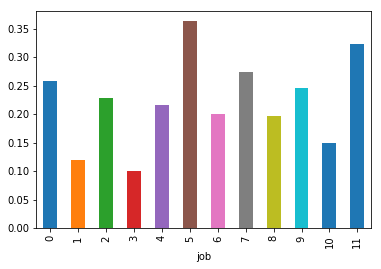

In [416]:
data_processed_time_2009.groupby('job').y.mean().plot(kind='bar')

# Train

In [40]:
data_processed_time.head()

id  age     ...      ct_events_day  mean_y_day
DATE                    ...                               
2008-05-05   1   56     ...                349    0.020057
2008-05-05   2   57     ...                349    0.020057
2008-05-05   3   37     ...                349    0.020057
2008-05-05   4   40     ...                349    0.020057
2008-05-05   5   56     ...                349    0.020057

[5 rows x 27 columns]

In [41]:
data_processed_time.drop(['mon_dow', 'mon_dow_p', 'ct_events_day', 'mean_y_day' ], axis=1, errors='ignore', inplace=True)

In [42]:
data_processed_time.reset_index(drop=True,inplace=True)

In [44]:
data_processed_time.head()

id  age  job         ...           day_id  year                 DATE
0   1   56    0         ...                0  2008  2008-05-05 00:00:00
1   2   57    1         ...                0  2008  2008-05-05 00:00:00
2   3   37    1         ...                0  2008  2008-05-05 00:00:00
3   4   40    2         ...                0  2008  2008-05-05 00:00:00
4   5   56    1         ...                0  2008  2008-05-05 00:00:00

[5 rows x 23 columns]

In [45]:
target = 'y'

In [50]:
# we omit date, month, year, euribor, because of uneven distribution seen above to avoid overfitting
labels = ['id', 'day_id', 'year', 'DATE', 'month', 'euribor3m',]

In [47]:
categoircal = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'day_of_week']

In [48]:
pd.set_option('display.max_columns', 50)

In [51]:
X = data_processed_time.drop(labels+[target], axis=1)

In [52]:
# y in X is a placeholder for validation. It's constant, so it doesn't have any effect on model, but it will be used 
# for shap validation, and trends correlation stats.
X['y'] = 0

In [53]:
y = data_processed_time[target]

In [54]:
lab = data_processed_time[labels]

In [643]:
for c in categoircal:
    X[c] = X[c].astype('category')

In [644]:
X.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
day_of_week          int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
nr.employed        float64
dtype: object

## Train 2008, validation 2009

In [431]:
train_msk = lab.year == 2008

In [432]:
val_msk = lab.year == 2009

In [433]:
X_train, y_train = X[train_msk], y[train_msk]

X_val, y_val = X[val_msk], y[val_msk]

### Baseline

In [660]:
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=30, verbose=1)

[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.500169
[3]	validation_0-auc:0.495172
[4]	validation_0-auc:0.495174
[5]	validation_0-auc:0.485293
[6]	validation_0-auc:0.4913
[7]	validation_0-auc:0.491763
[8]	validation_0-auc:0.490896
[9]	validation_0-auc:0.502766
[10]	validation_0-auc:0.506572
[11]	validation_0-auc:0.515921
[12]	validation_0-auc:0.573986
[13]	validation_0-auc:0.574989
[14]	validation_0-auc:0.574424
[15]	validation_0-auc:0.605302
[16]	validation_0-auc:0.615042
[17]	validation_0-auc:0.606595
[18]	validation_0-auc:0.606233
[19]	validation_0-auc:0.598484
[20]	validation_0-auc:0.597178
[21]	validation_0-auc:0.591839
[22]	validation_0-auc:0.589509
[23]	validation_0-auc:0.585089
[24]	validation_0-auc:0.580057
[25]	validation_0-auc:0.582203
[26]	validation_0-auc:0.579984
[27]	validation_0-auc:0.579251
[28]	validation_0-auc:0.583542
[29]	validation_0-auc:0.581913
[30]	validation_0-auc:0.5795

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### shap values

In [612]:
X_val_shap = predict_shap_sk(clf, X_val)

In [620]:
X_train_shap = predict_shap_sk(clf, X_train)

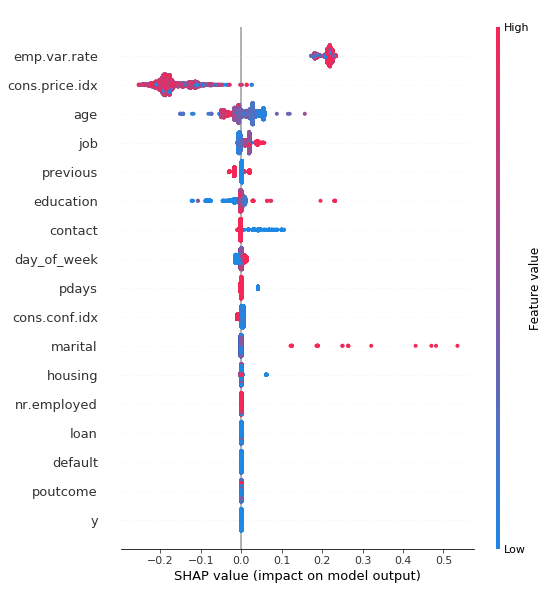

In [613]:
shap.summary_plot(X_val_shap, X_val)

In [104]:
#making copies of datasets for analysis
X_val_cp = X_val.copy()
X_val_cp.y = y_val
X_train_cp = X_train.copy()
X_train_cp.y = y_train
X_train_cp.y.value_counts()

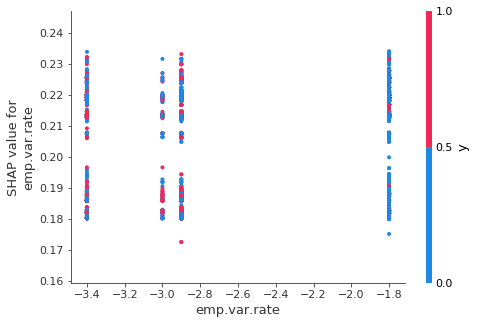

In [619]:
shap.dependence_plot('emp.var.rate', X_val_shap, X_val_cp, interaction_index='y')

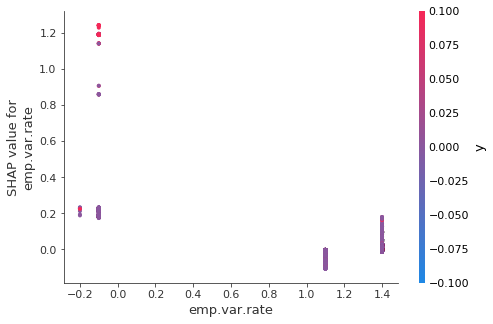

In [625]:
shap.dependence_plot('emp.var.rate', X_train_shap, X_train_cp, interaction_index='y')

#### Trend analysis

                                       Plots for cons.price.idx                                       
Only one bin created for cons.price.idx. Correlation can't be calculated
                                           Train data plots                                           


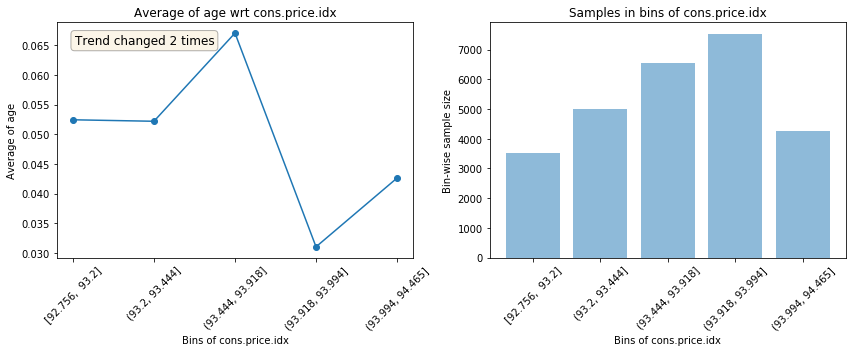

                                           Test data plots                                            


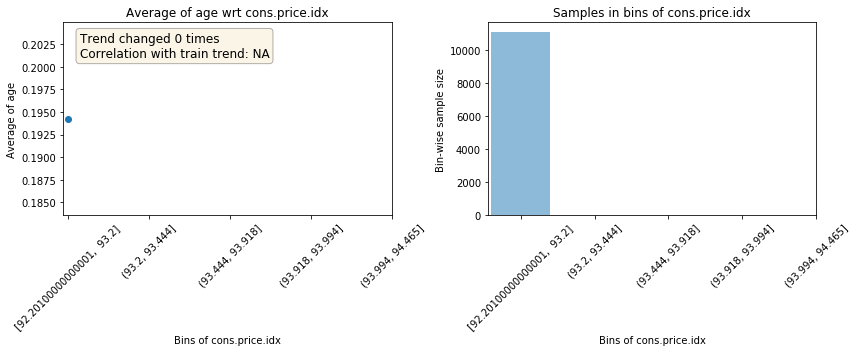

--------------------------------------------------------------------------------------------------------------




In [607]:
get_univariate_plots(X_train_cp, 'age', ["cons.price.idx"], data_test=X_val_cp)

In [629]:
X_train.dtypes

age                 int64
job                 int64
marital             int64
education           int64
default             int64
housing             int64
loan                int64
contact             int64
day_of_week         int64
pdays               int64
previous            int64
poutcome            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
nr.employed       float64
y                   int64
dtype: object

In [365]:
continuous_vars = list(set(X.columns) - set(categoircal))

In [673]:
trend_stats = get_trend_stats(X_train_cp, 'y', features_list=continuous_vars, data_test=X_val_cp )

Only one bin created for nr.employed. Correlation can't be calculated
Only one bin created for cons.price.idx. Correlation can't be calculated
Only one bin created for emp.var.rate. Correlation can't be calculated
Only one bin created for pdays. Correlation can't be calculated
Returning stats for all numeric features


In [674]:
trend_stats.sort_values("Trend_correlation",  ascending=False)

Feature  Trend_changes  Trend_changes_test  Trend_correlation
2             age              4                   1             0.3432
0     nr.employed              1                   0             0.0000
1  cons.price.idx              2                   0             0.0000
5    emp.var.rate              1                   0             0.0000
6           pdays              0                   0             0.0000
3   cons.conf.idx              1                   0            -1.0000
4        previous              0                   0            -1.0000

We see, that most continuous variables, have 0 or negative correlation. Including those economic factors we haven't dropped yet.  Let's use another method to check, whether train can be used to check test reliably

### Adversarial cross-validation

This method is call adversarial cross-validation. We create a model to distinguish between train and test. If the model does good, it means, that train and test are distinguishable, i.e come from different distribution, so model trained on train data can't be used for test. We can analyze model's feature importance to see which features are the cause of the difference between datasets

In [60]:
# making a dataset for adversarial CV
# target: 0 is train 1 is test 
# using 70/30 split, stratified by target
X_adv = pd.concat([X_train, X_val])
y_adv = pd.concat([pd.Series(np.repeat(0, X_train.shape[0])), pd.Series(np.repeat(1, X_val.shape[0]))])
X_adv_train, X_adv_val, y_adv_train, y_adv_val = train_test_split(X_adv, y_adv, train_size=.7, random_state=9, stratify=y_adv, )


In [61]:
print('Adversarial train target value counts')
y_adv_train.value_counts()

Adversarial train target value counts


0    18815
1     7784
dtype: int64

In [62]:
print('Adversarial test target value counts')

y_adv_val.value_counts()

Adversarial test target value counts


0    8064
1    3336
dtype: int64

In [63]:
clf_adv = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

In [64]:
# fitting xgboost
clf_adv.fit(X_adv_train, y_adv_train, eval_set=[(X_adv_val, y_adv_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:1
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:1
[20]	validation_0-auc:1
[30]	validation_0-auc:1
Stopping. Best iteration:
[0]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
print('Adversarial CV model score, step 1, auc: ', clf_adv.best_score)

Adversarial CV model score, step 1, auc:  1.0


We see roc auc 1 for validation. That means model separated classes perfectly. Let's which feature was used. We can use built-in feature impotance so far.

In [66]:
print('Adversarial CV model feature importance, xgb, built-in')
pd.Series(clf_adv.get_booster().get_fscore()).sort_values(ascending=False)

Adversarial CV model feature importance, xgb, built-in


emp.var.rate    31
dtype: int64

Let's drop it and see, how the validation score responds

In [67]:
X_adv_train_2 = X_adv_train.drop('emp.var.rate', axis=1, )

X_adv_val_2 = X_adv_val.drop('emp.var.rate', axis=1, )

In [68]:
clf_adv_2 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )
clf_adv_2.fit(X_adv_train_2, y_adv_train, eval_set=[(X_adv_val_2, y_adv_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:1
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:1
[20]	validation_0-auc:1
[30]	validation_0-auc:1
Stopping. Best iteration:
[0]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
print('Adversarial CV model score, step 2, auc: ', clf_adv_2.best_score)

Adversarial CV model score, step 2, auc:  1.0


Still 1. Let's see which features were used now

In [70]:
print('Adversarial CV model feature importance, xgb, built-in, step 2')

pd.Series(clf_adv_2.get_booster().get_fscore()).sort_values(ascending=False)

Adversarial CV model feature importance, xgb, built-in, step 2


nr.employed    31
dtype: int64

Removing this feature as well 

In [71]:
X_adv_train_3 = X_adv_train_2.drop('nr.employed', axis=1, )

X_adv_val_3 = X_adv_val_2.drop('nr.employed', axis=1, )


In [72]:
clf_adv_3 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

clf_adv_3.fit(X_adv_train_3, y_adv_train, eval_set=[(X_adv_val_3, y_adv_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:0.999628
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:0.999628
[20]	validation_0-auc:0.999628
[30]	validation_0-auc:0.999628
Stopping. Best iteration:
[0]	validation_0-auc:0.999628



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
print('Adversarial CV model score, step 3, auc: ', clf_adv_3.best_score)

Adversarial CV model score, step 3, auc:  0.999628


Wow, the adversarial validation score dropped a little bit. Let's see the features.

In [74]:
print('Adversarial CV model feature importance, xgb, built-in, step 3')

pd.Series(clf_adv_3.get_booster().get_fscore()).sort_values(ascending=False)

Adversarial CV model feature importance, xgb, built-in, step 3


cons.price.idx    31
dtype: int64

We are observing that those econmic factor features which had mismatched trends in above analysis causes the model to overfit. Let's remove them both to save time. 

In [75]:
features_drop = ['cons.price.idx', 'cons.conf.idx']

X_adv_train_4 = X_adv_train_3.drop(features_drop, axis=1,)
X_adv_val_4 = X_adv_val_3.drop(features_drop, axis=1, )

In [76]:
clf_adv_4 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

clf_adv_4.fit(X_adv_train_4, y_adv_train, eval_set=[(X_adv_val_4, y_adv_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:0.811271
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:0.834178
[20]	validation_0-auc:0.839307
[30]	validation_0-auc:0.844581
[40]	validation_0-auc:0.845932
[50]	validation_0-auc:0.847284
[60]	validation_0-auc:0.848681
[70]	validation_0-auc:0.850005
[80]	validation_0-auc:0.851001
[90]	validation_0-auc:0.851809
[100]	validation_0-auc:0.852709
[110]	validation_0-auc:0.853186
[120]	validation_0-auc:0.853844
[130]	validation_0-auc:0.8543
[140]	validation_0-auc:0.854857
[150]	validation_0-auc:0.855032
[160]	validation_0-auc:0.855368
[170]	validation_0-auc:0.855638
[180]	validation_0-auc:0.855872
[190]	validation_0-auc:0.856126
[200]	validation_0-auc:0.856323
[210]	validation_0-auc:0.856535
[220]	validation_0-auc:0.856661
[230]	validation_0-auc:0.856632
[240]	validation_0-auc:0.856905
[250]	validation_0-auc:0.857111
[260]	validation_0-auc:0.857241
[270]	validation_0-auc:0.857388
[280]	validation_0-auc:0.85731
[290]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [78]:
print('Adversarial CV model score, step 4, auc: ', clf_adv_4.best_score)

Adversarial CV model score, step 4, auc:  0.859349


In [79]:
print('Adversarial CV model feature importance, xgb, built-in, step 4')

pd.Series(clf_adv_4.get_booster().get_fscore()).sort_values(ascending=False)

Adversarial CV model feature importance, xgb, built-in, step 4


age            3032
job            1641
education      1306
day_of_week    1091
marital         526
housing         377
pdays           370
default         336
previous        322
contact         261
loan            217
dtype: int64

We see, that now more features come into play. Let's use shap to analyze more closely.

In [80]:
shap_val_adv_4 = predict_shap_sk(clf_adv_4, X_adv_val_4)

In [81]:
shap.initjs()

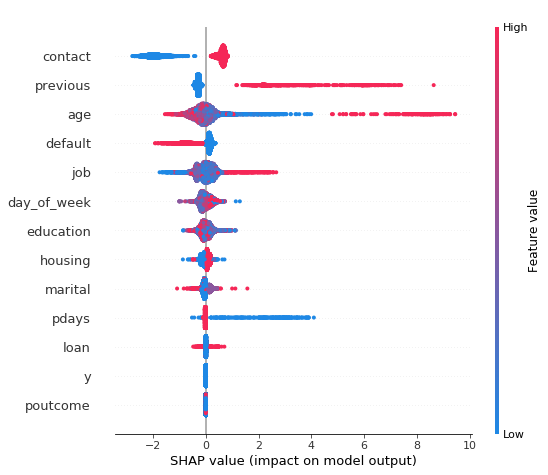

In [82]:
shap.summary_plot(shap_val_adv_4, X_adv_val_4)

In [83]:
X_adv_val_4_cp = X_adv_val_4.copy()
X_adv_val_4_cp['y'] = y_adv_val.values

In [84]:
X_adv_train_4_cp = X_adv_train_4.copy()
X_adv_train_4_cp['y'] = y_adv_train.values

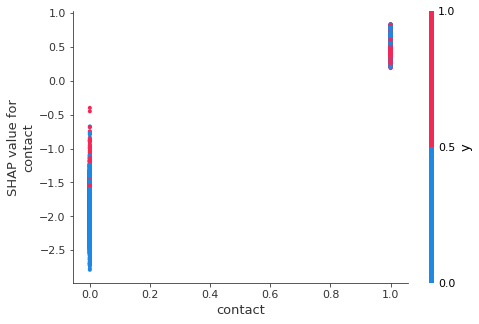

In [85]:
shap.dependence_plot('contact', shap_val_adv_4, X_adv_val_4_cp, interaction_index='y')

We see, that in 2009 there are more people, who have been contacted before. In 2008 thre are less such people. This feature might be useful, but not when we use 2008 as train. 

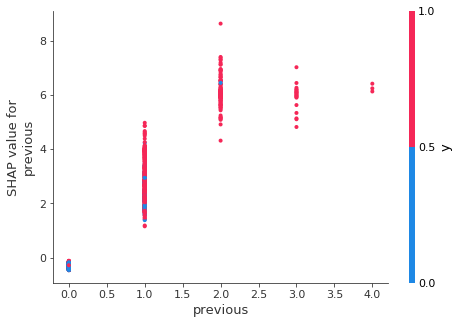

In [86]:
shap.dependence_plot('previous', shap_val_adv_4, X_adv_val_4_cp, interaction_index='y')

The same about number of previous contacts. It might be useful when we predict 2010 on 2009, but for 2008 vs 2009 their distributions are too different. 

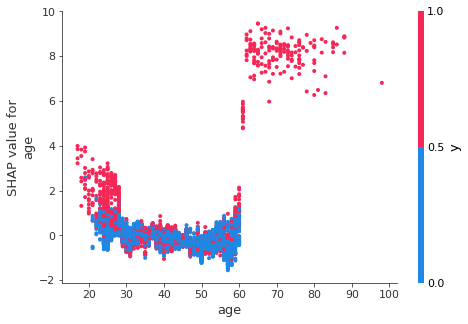

In [87]:
shap.dependence_plot('age', shap_val_adv_4, X_adv_val_4_cp, interaction_index='y')

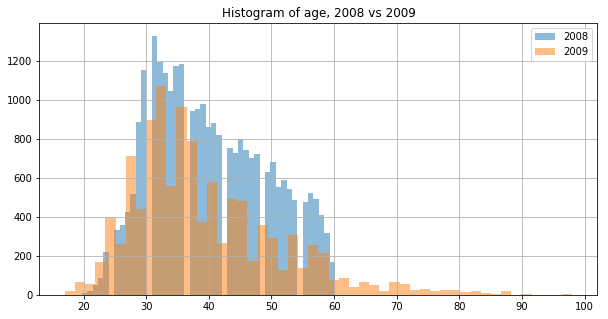

In [90]:
plt.figure(figsize=(10, 5))
plt.title("Histogram of age, 2008 vs 2009");
X_train.age.hist(bins=50, alpha=.5)
X_val.age.hist(bins=50, alpha=.5)
plt.legend(labels=['2008', '2009']);


We clearly see, that they decide to reach out to older people in 2009, and maybe it's a good idea. But we need to somehow handle in, so the model would not overfit. Let's make a category out of age

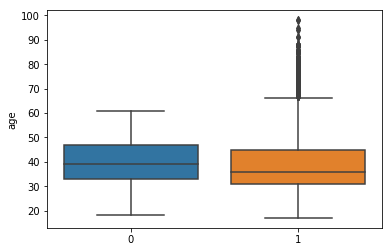

In [91]:
sns.boxplot(x=y_adv.reset_index(drop=True), y=X_adv.age.reset_index(drop=True))

In [182]:
X_adv_val_4['age_c'] = pd.cut(X_adv_val_4.age,[16, 26, 40, 55, np.inf], labels=False)

In [183]:
X_adv_train_4['age_c'] = pd.cut(X_adv_train_4.age,[16, 26, 40, 55, np.inf], labels=False)

So we are dropping the previous, contact and age feautres, and keeping age categories.

In [184]:
features_drop = ['previous', 'contact', 'age']

X_adv_train_5 = X_adv_train_4.drop(features_drop, axis=1,)
X_adv_val_5 = X_adv_val_4.drop(features_drop, axis=1, )

In [185]:
clf_adv_5 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

clf_adv_5.fit(X_adv_train_5, y_adv_train, eval_set=[(X_adv_val_5, y_adv_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:0.718881
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:0.73422
[20]	validation_0-auc:0.745614
[30]	validation_0-auc:0.749444
[40]	validation_0-auc:0.750559
[50]	validation_0-auc:0.751891
[60]	validation_0-auc:0.752518
[70]	validation_0-auc:0.753533
[80]	validation_0-auc:0.754558
[90]	validation_0-auc:0.755053
[100]	validation_0-auc:0.755655
[110]	validation_0-auc:0.756088
[120]	validation_0-auc:0.756363
[130]	validation_0-auc:0.756634
[140]	validation_0-auc:0.756821
[150]	validation_0-auc:0.757048
[160]	validation_0-auc:0.757055
[170]	validation_0-auc:0.757313
[180]	validation_0-auc:0.757188
[190]	validation_0-auc:0.757213
[200]	validation_0-auc:0.757449
[210]	validation_0-auc:0.757527
[220]	validation_0-auc:0.757547
[230]	validation_0-auc:0.757449
[240]	validation_0-auc:0.757378
[250]	validation_0-auc:0.757374
Stopping. Best iteration:
[225]	validation_0-auc:0.757622



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [186]:
print('Adversarial CV model score, step 5, auc: ', clf_adv_5.best_score)

Adversarial CV model score, step 5, auc:  0.757622


We dropped to 0.75 auc. That means our datasets have become more similar. 

In [187]:
shap_val_adv_5 = predict_shap_sk(clf_adv_5, X_adv_val_5)

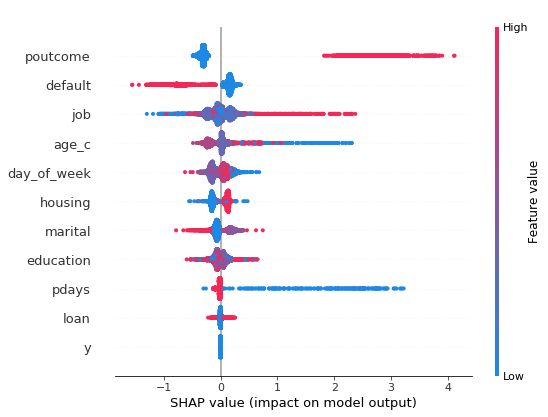

In [188]:
shap.summary_plot(shap_val_adv_5, X_adv_val_5)

In [189]:
X_adv_val_5_cp = X_adv_val_5.copy()
X_adv_val_5_cp['y'] = y_adv_val.values

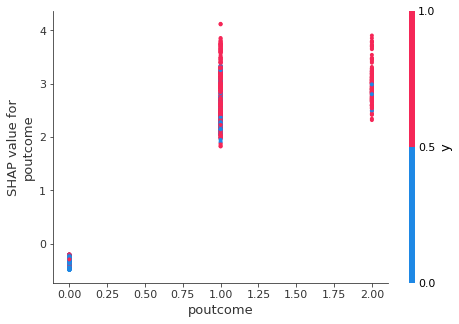

In [190]:
shap.dependence_plot('poutcome', shap_val_adv_5, X_adv_val_5_cp, interaction_index='y')

In [191]:
X_train.poutcome.value_counts()

0    26169
1      678
2       32
Name: poutcome, dtype: int64

In [192]:
X_val.poutcome.value_counts()

0    7535
1    2916
2     669
Name: poutcome, dtype: int64

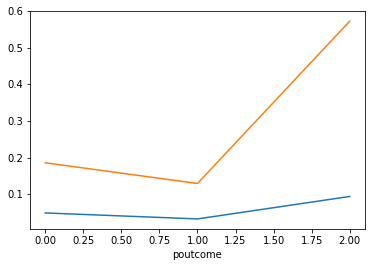

In [193]:
X_train_cp.groupby('poutcome').y.mean().plot()
X_val_cp.groupby('poutcome').y.mean().plot()

Ok, let's keep poutcome

Ok, I think we are running out fetures :) 0.68 is kind of a bordeline case. Our train is pretty different from test, but it's as good as it gets.

In [110]:
non_overfit_feautres = X_adv_train_5.columns.tolist()

In [111]:
print ('non-overfit features: ', ', '.join(non_overfit_feautres )) 

non-overfit features:  job, marital, education, default, housing, loan, day_of_week, pdays, poutcome, y, age_c


In [112]:
non_overfit_feautres

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'day_of_week',
 'pdays',
 'poutcome',
 'y',
 'age_c']

### train without overfit features

In [194]:
X['age_c'] = pd.cut(X.age,[16, 26, 40, 55, np.inf], labels=False)

In [195]:
X_train_no = X[train_msk][non_overfit_feautres]

X_val_no = X[val_msk][non_overfit_feautres]

In [196]:
clf_no = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

clf_no.fit(X_train_no, y_train, eval_set=[(X_val_no, y_val)], eval_metric='auc', early_stopping_rounds=100, verbose=1)


[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[3]	validation_0-auc:0.5
[4]	validation_0-auc:0.5
[5]	validation_0-auc:0.492959
[6]	validation_0-auc:0.500535
[7]	validation_0-auc:0.510243
[8]	validation_0-auc:0.519058
[9]	validation_0-auc:0.519056
[10]	validation_0-auc:0.519056
[11]	validation_0-auc:0.58461
[12]	validation_0-auc:0.582402
[13]	validation_0-auc:0.589705
[14]	validation_0-auc:0.586561
[15]	validation_0-auc:0.580223
[16]	validation_0-auc:0.579903
[17]	validation_0-auc:0.575496
[18]	validation_0-auc:0.574185
[19]	validation_0-auc:0.575497
[20]	validation_0-auc:0.576714
[21]	validation_0-auc:0.575263
[22]	validation_0-auc:0.580413
[23]	validation_0-auc:0.572104
[24]	validation_0-auc:0.585192
[25]	validation_0-auc:0.584428
[26]	validation_0-auc:0.585047
[27]	validation_0-auc:0.585019
[28]	validation_0-auc:0.587588
[29]	validation_0-auc:0.583611
[30]	validation_0-auc:0.579843
[31]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

We see auc is about the same, as was in the baseline, but the number of trees here 101 vs 16 in baseline. That means that boosting algorithm had more information to extract and that's why needed more trees. That means, that the model is more stable. Also, we removed the most features which causes overfitting to a period. 

In [197]:
shap_train_no = predict_shap_sk(clf_no, X_train_no)

shap_val_no = predict_shap_sk(clf_no, X_val_no)

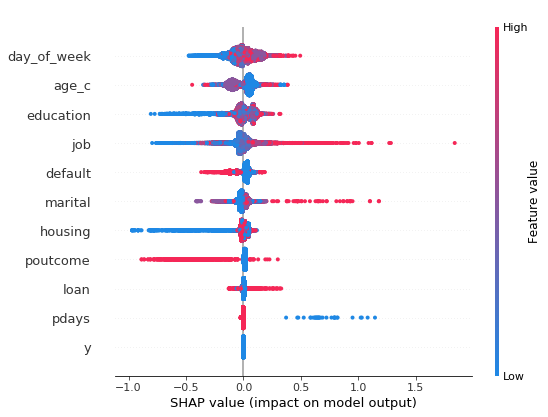

In [198]:
shap.summary_plot(shap_train_no, X_train_no)

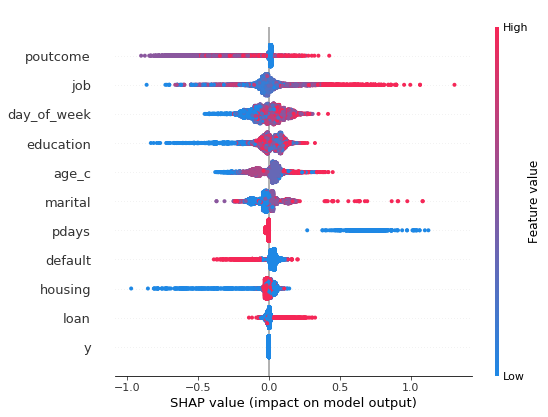

In [199]:
shap.summary_plot(shap_val_no, X_val_no)

We see, that poutcome is more important for 2009 than for 2008, and we see from plot in previous chapter, that it's more evenly distributed in 2009 than 2008

Let's analyze feature interactions 

In [881]:
xgbfir.saveXgbFI(clf_no, X_train_no.columns, '../meta/clf_no.xlsx')

Here are top intrecations from the report:

Interaction	Gain

day_of_week|job	220,6431775501

age_c|job	214,0893337006

day_of_week|education	197,8426317242

education|job	158,3312357752

In [119]:
def make_interaction(df, f1, f2):
    df['INT__' + f1 +'__' + f2] = \
        pd.factorize(df[f1].astype(str)+ '_' + df[f2].astype(str))[0]
    return df

In [120]:
X= make_interaction(X, 'day_of_week', 'job')

In [121]:
X= make_interaction(X, 'age_c', 'job')

In [122]:
X= make_interaction(X, 'education', 'job')

In [123]:
interaction_feats = ['INT__day_of_week__job', 'INT__age_c__job', 'INT__education__job']

### with interactions

In [277]:
X_train_no_int = X[train_msk][non_overfit_feautres + interaction_feats]

X_val_no_int = X[val_msk][non_overfit_feautres + interaction_feats]

In [452]:
clf_no_int = XGBClassifier(n_estimators=10000, max_depth=3, subsample=.6, colsample_bytree=1 ,  n_jobs= 8, random_state=9, scale_pos_weight=2 )

clf_no_int.fit(X_train_no_int, y_train, eval_set=[(X_val_no_int, y_val)], eval_metric='auc', early_stopping_rounds=100, verbose=100)


[0]	validation_0-auc:0.500874
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.584722
Stopping. Best iteration:
[6]	validation_0-auc:0.647664



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=0.6)

In [229]:
shap_train_no_int = predict_shap_sk(clf_no_int, X_train_no_int)

shap_val_no_int = predict_shap_sk(clf_no_int, X_val_no_int)

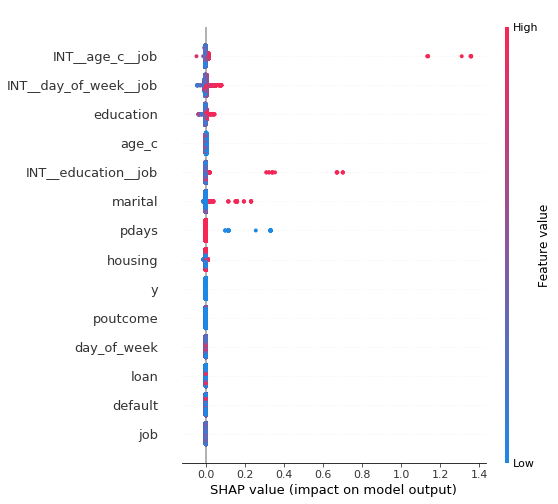

In [230]:
shap.summary_plot(shap_train_no_int, X_train_no_int)

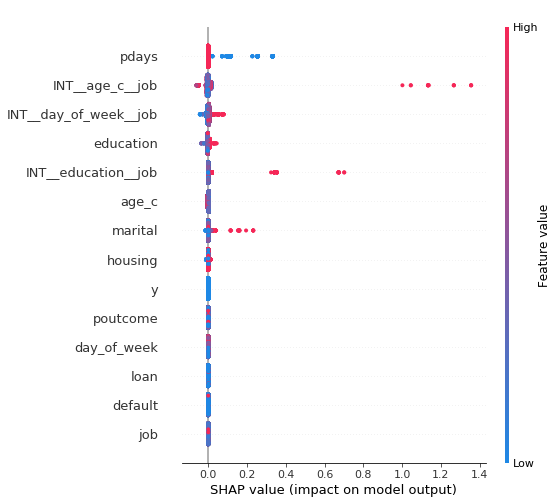

In [231]:
shap.summary_plot(shap_val_no_int, X_val_no_int)

First evaluation score became worse. Normally adding interactions improves results on the same. Not in this case. That's because train and test belong to different distributions. That makes train overfit to interactions. I added more regularization to the model (made smaller, tree depth, made subsample on each tree 0.6 ) and that improved the model score to 0.63979, chaning scale pos weight to 2(deals with class imbalance) increased score to 0.647664

### Light GBM

Lightgbm is known for handling categories better. Let's see what it can do with categorical data. 

In [129]:
from lightgbm import LGBMClassifier

In [278]:
X_train_no_cat = X_train_no.copy()

In [279]:
X_val_no_cat = X_val_no.copy()

In [280]:
for c in categoircal:
    if c in X_train_no_cat.columns:
        X_train_no_cat[c] = X_train_no_cat[c].astype('category')
        X_val_no_cat[c] = X_val_no_cat[c].astype('category')    

In [281]:
X_train_no_cat.dtypes

job            category
marital        category
education      category
default        category
housing        category
loan           category
day_of_week    category
pdays             int64
poutcome       category
y                 int64
age_c             int64
dtype: object

In [282]:
lgb_no = LGBMClassifier(num_leaves=10, n_estimators=1000, random_state=9, min_child_weight=1,
                        subsample_freq=1 , subsample=.6, colsample_bytree=.6  )
lgb_no.fit(X_train_no_cat, y_train, eval_set=[(X_val_no_cat, y_val)], eval_metric='auc', early_stopping_rounds=100, verbose=100)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.586815	valid_0's binary_logloss: 0.624452
Early stopping, best iteration is:
[13]	valid_0's auc: 0.637238	valid_0's binary_logloss: 0.614106


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=10, objective=None,
        random_state=9, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.6, subsample_for_bin=200000, subsample_freq=1)

Lightgbms model is also highly regularized - small number of leaves, small colsample and subsample. Playing around with parameters, I was not able to reach xgboost score

In [288]:
X_train_no_int_cat = X_train_no_int.copy()

In [289]:
X_val_no_int_cat = X_val_no_int.copy()

In [290]:
for c in categoircal + interaction_feats:
    if c in X_train_no_int_cat.columns:
        X_train_no_int_cat[c] = X_train_no_int_cat[c].astype('category')
        X_val_no_int_cat[c] = X_val_no_int_cat[c].astype('category')    

But i can't handle overfitting with interation features for lightGBM

In [318]:
lgb_no_int = LGBMClassifier(num_leaves=6, n_estimators=1000, random_state=9, min_child_weight=.5,
                        subsample_freq=1 , subsample=.8, colsample_bytree=.8  )
lgb_no_int.fit(X_train_no_int_cat, y_train, eval_set=[(X_val_no_int_cat, y_val)], eval_metric='auc', early_stopping_rounds=100, verbose=100)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.511438	valid_0's binary_logloss: 0.647476
Early stopping, best iteration is:
[3]	valid_0's auc: 0.522126	valid_0's binary_logloss: 0.626286


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.5, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=6, objective=None,
        random_state=9, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=1)

### Catboost

Catboost is an open-source gradient boosting library from Yandex company. It is known for advanced work with categorical data. 

In [283]:
from catboost import CatBoostClassifier

In [284]:
ctb_clf_no_cats = CatBoostClassifier(random_state=9)

In [285]:
X_val[X_val_no_cat.iloc[:, 10].isnull()]

Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, day_of_week, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, nr.employed, y]
Index: []

In [286]:
X_val_no[X_val_no_cat.iloc[:, 10].isnull()]

Empty DataFrame
Columns: [job, marital, education, default, housing, loan, day_of_week, pdays, poutcome, y, age_c]
Index: []

In [325]:
cat_inds = np.where(X_val_no.columns.isin(categoircal))[0]

In [332]:
ctb_clf_no_cats.fit(X_train_no_cat, y_train, eval_set=[(X_val_no_cat, y_val)], cat_features=cat_inds, early_stopping_rounds=100, verbose=10)

Learning rate set to 0.11024
0:	learn: 0.5582683	test: 0.6062375	best: 0.6062375 (0)	total: 15.7ms	remaining: 15.7s
10:	learn: 0.2138205	test: 0.5191080	best: 0.4865549 (5)	total: 225ms	remaining: 20.3s
20:	learn: 0.1952064	test: 0.5819827	best: 0.4865549 (5)	total: 385ms	remaining: 17.9s
30:	learn: 0.1936674	test: 0.6130835	best: 0.4865549 (5)	total: 527ms	remaining: 16.5s
40:	learn: 0.1933574	test: 0.6201112	best: 0.4865549 (5)	total: 672ms	remaining: 15.7s
50:	learn: 0.1930682	test: 0.6243464	best: 0.4865549 (5)	total: 881ms	remaining: 16.4s
60:	learn: 0.1928435	test: 0.6273821	best: 0.4865549 (5)	total: 1.12s	remaining: 17.2s
70:	learn: 0.1926537	test: 0.6291586	best: 0.4865549 (5)	total: 1.35s	remaining: 17.7s
80:	learn: 0.1924031	test: 0.6246357	best: 0.4865549 (5)	total: 1.61s	remaining: 18.3s
90:	learn: 0.1921637	test: 0.6244238	best: 0.4865549 (5)	total: 1.79s	remaining: 17.9s
100:	learn: 0.1915258	test: 0.6221138	best: 0.4865549 (5)	total: 2.12s	remaining: 18.8s
Stopped by ov

Catboot also massively overfits the train

### Summary

As it was clear from the beginning, train would overfit, because datset is sampled poorly. I did everything possible to avoid overfitting. The best model is xgboost with interaction feature. Its validation score is **0.647664**

#### Explaining best model's prediction

From shap summary we see that, pdays and interactions of job and age, and day of week and job are the most predictive features

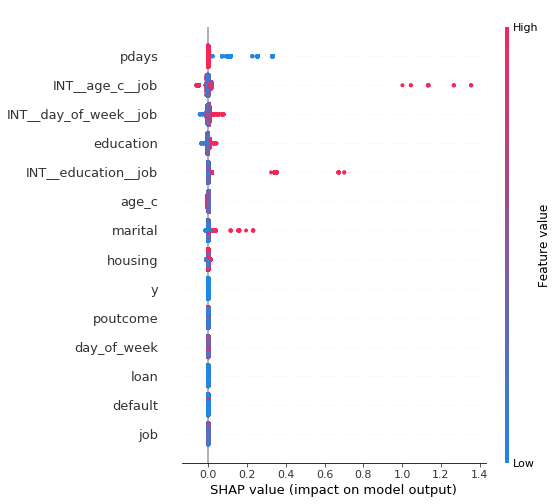

In [453]:
shap.summary_plot(shap_val_no_int, X_val_no_int)

In [528]:
# getting predictions for validation score
xgb_no_int_val_preds = clf_no_int.predict_proba(X_val_no_int)[:,1]

print('validation auc: ', roc_auc_score(y_val, xgb_no_int_val_preds))

print('validation map: ',   average_precision_score(y_val, xgb_no_int_val_preds) )

validation auc:  0.6476643105158729
validation map:  0.3269548807719874


In [530]:
print ('validation target balance of classes')
y_val.value_counts()

validation target balance of classes


0    8960
1    2160
Name: y, dtype: int64

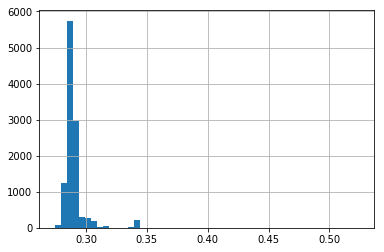

In [458]:
pd.Series(xgb_no_int_val_preds).hist(bins=50)

In [531]:
print('validation target mean: ', y_val.mean() )

validation target mean:  0.19424460431654678


In [532]:
print('validation predictions mean: ', np.mean(xgb_no_int_val_preds) )

validation predictions mean:  0.29040346


The mean of predictions is higher, because we increased scale_pos_weight

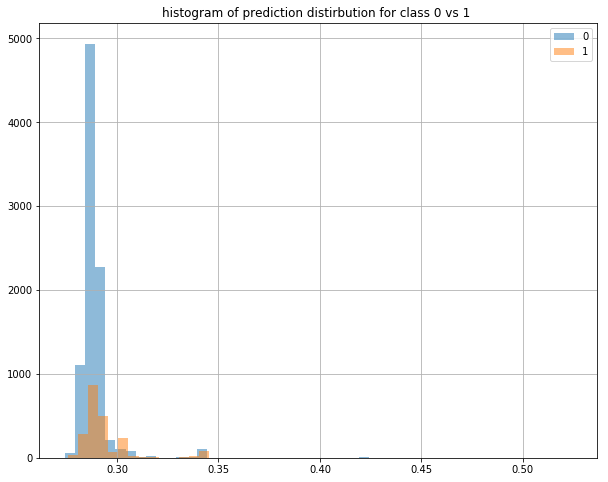

In [535]:
plt.figure(figsize=(10,8))
plt.title('histogram of prediction distirbution for class 0 vs 1 ')
pd.Series(xgb_no_int_val_preds[y_val == 0]).hist(bins=50, alpha=.5);
pd.Series(xgb_no_int_val_preds[y_val == 1]).hist(bins=50, alpha=.5);
plt.legend(labels = ['0', '1']);

In [472]:
preds_df = pd.Series(xgb_no_int_val_preds).to_frame('preds')

preds_df['y'] = y_val.values

Mean target by prediction mean

In [485]:
preds_df.groupby(pd.qcut(preds_df.preds, 10)).y.mean().sort_values(ascending=False)

preds
(0.2938, 0.5243]    0.468891
(0.2918, 0.2938]    0.252298
(0.2891, 0.2895]    0.224181
(0.2895, 0.2918]    0.215126
(0.2876, 0.2888]    0.155296
(0.2863, 0.2876]    0.154676
(0.2848, 0.2863]    0.141805
(0.2888, 0.2891]    0.134855
(0.2833, 0.2848]    0.119298
(0.2741, 0.2833]    0.112174
Name: y, dtype: float64

Coverage of CLASS 1 by prediction bin

In [481]:
preds_df.groupby(pd.qcut(preds_df.preds, 10)).y.sum().sort_values(ascending=False) / preds_df.y.sum()

preds
(0.2938, 0.5243]    0.240741
(0.2895, 0.2918]    0.118519
(0.2918, 0.2938]    0.114352
(0.2888, 0.2891]    0.090278
(0.2891, 0.2895]    0.082407
(0.2876, 0.2888]    0.080093
(0.2863, 0.2876]    0.079630
(0.2848, 0.2863]    0.071296
(0.2833, 0.2848]    0.062963
(0.2741, 0.2833]    0.059722
Name: y, dtype: float64

Cumulative coverage of CLASS 1 by prediction bin

In [483]:
(preds_df.groupby(pd.qcut(preds_df.preds, 10)).y.sum().sort_values(ascending=False) / preds_df.y.sum()).cumsum()

preds
(0.2938, 0.5243]    0.240741
(0.2895, 0.2918]    0.359259
(0.2918, 0.2938]    0.473611
(0.2888, 0.2891]    0.563889
(0.2891, 0.2895]    0.646296
(0.2876, 0.2888]    0.726389
(0.2863, 0.2876]    0.806019
(0.2848, 0.2863]    0.877315
(0.2833, 0.2848]    0.940278
(0.2741, 0.2833]    1.000000
Name: y, dtype: float64

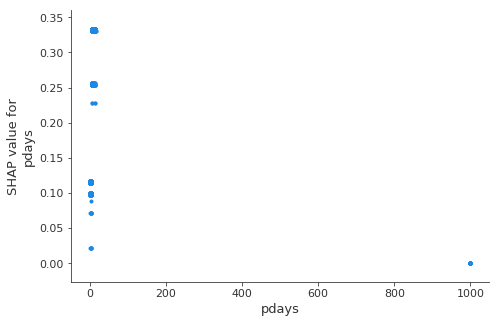

In [537]:
shap.dependence_plot('pdays', shap_val_no_int, X_val_no_int, interaction_index=None)

In [538]:
zoom_msk = X_val_no_int.pdays < 999

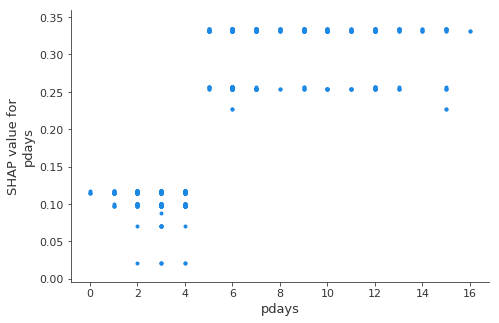

In [539]:
shap.dependence_plot('pdays', shap_val_no_int[zoom_msk], X_val_no_int[zoom_msk], interaction_index=None)

We see that if we contacted a customer less than 5 days before, we are more unlikely to get a positive reaction, opposite from 6 between 16 days

##### exploring false positves

Let's see which cases our models predicts wrong as positive to better understand the data

In [492]:
false_p_msk = ( (preds_df.y == 0) & (preds_df.preds > .4) ).values

In [494]:
shap.force_plot(shap_val_no_int[false_p_msk], X_val_no_int[false_p_msk])

We see that for half samples the interaction of age and job is the most important feature, and for another half - interaction of education and job

We see that INT__age_c__job is a very strong indicator of positive outcome

In [497]:
X_val[X_val.INT__age_c__job == 44][['age','job']]

age  job
26913   26    9
29535   25    9
34898   26    9
35350   24    9
35351   24    9
35352   24    9
35353   24    9
35354   24    9
35356   24    9

In [501]:
job_ind = joblib.load("../meta/job_ind")

In [540]:
print("job for index 9 is ", job_ind[9] )

job for index 9 is  unknown


In [541]:
y_val[X_val.INT__age_c__job == 44].mean()

0.5555555555555556

Ok, if you are between age 24 and 26 and your job is unknown, you are likely to have money you want to put on a deposit, according to the data. But yeah that's where ambiguity comes into place.

In [505]:
X_val[X_val.INT__education__job == 84][['education','job']]

education  job
27066          2   11
35051          2   11
35189          2   11
36402          2   11
36529          2   11
37384          2   11
37385          2   11
37480          2   11

In [506]:
education_ind = joblib.load("../meta/education_ind")

In [542]:
print('job 11 is ', job_ind[11] )

job 11 is  student


In [543]:
print('education is ', education_ind[2])

education is  basic.6y


In [545]:
data[(data.job == 'student') & (data.education == 'basic.6y') ].ix[27000:38000].y.value_counts()

no     5
yes    3
Name: y, dtype: int64

So, here false positives are explainable as well 

In [519]:
X_val[X_val.INT__age_c__job == 47][['age','job']]

age  job
36054   17   11
36445   17   11
36464   17   11
36483   17   11
37165   17   11

In [520]:
y_val[X_val.INT__age_c__job == 47].mean()

0.4

So 40% of 17 year old students opened the deposit in 2009 according to this data. This looks like a random pattern. We might want to dismiss to, so as not to train on outliers

## Train 2009, predict 2010

### Baseline

In [343]:
inital_feats = X.columns[:-4].tolist()

In [344]:
train_msk = lab.year == 2009

In [345]:
val_msk = lab.year == 2010

In [387]:
X_train_09, y_train_09 = X[train_msk][inital_feats+['age_c']], y[train_msk]

In [388]:
X_val_09, y_val_09 = X[val_msk][inital_feats + ['age_c']], y[val_msk]

In [353]:
clf_09 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

In [357]:
clf_09.fit(X_train_09, y_train, eval_set=[(X_val_09, y_val)], eval_metric='auc', early_stopping_rounds=30, verbose=1)

[0]	validation_0-auc:0.647337
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.649374
[2]	validation_0-auc:0.649374
[3]	validation_0-auc:0.649374
[4]	validation_0-auc:0.67614
[5]	validation_0-auc:0.67614
[6]	validation_0-auc:0.69935
[7]	validation_0-auc:0.699045
[8]	validation_0-auc:0.698482
[9]	validation_0-auc:0.698407
[10]	validation_0-auc:0.685923
[11]	validation_0-auc:0.676697
[12]	validation_0-auc:0.684787
[13]	validation_0-auc:0.684148
[14]	validation_0-auc:0.687676
[15]	validation_0-auc:0.686523
[16]	validation_0-auc:0.680846
[17]	validation_0-auc:0.684587
[18]	validation_0-auc:0.682881
[19]	validation_0-auc:0.68306
[20]	validation_0-auc:0.682122
[21]	validation_0-auc:0.682686
[22]	validation_0-auc:0.68075
[23]	validation_0-auc:0.680118
[24]	validation_0-auc:0.679439
[25]	validation_0-auc:0.688796
[26]	validation_0-auc:0.687397
[27]	validation_0-auc:0.689939
[28]	validation_0-auc:0.691014
[29]	validation_0-auc:0.695528
[30]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [358]:
pd.Series(clf_09.get_booster().get_fscore()).sort_values(ascending=False)

age               269
job               124
day_of_week       124
cons.price.idx     98
education          78
emp.var.rate       73
pdays              71
cons.conf.idx      49
contact            48
previous           40
loan               36
marital            35
housing            31
poutcome           22
default            21
dtype: int64

In [390]:
#making copies of datasets for analysis
X_val_09_cp = X_val_09.copy()
X_val_09_cp.y = y_val_09
X_train_09_cp = X_train_09.copy()
X_train_09_cp.y = y_train_09


#### Shap analysis

In [361]:
X_val_09_shap = predict_shap_sk(clf_09, X_val_09)

X_train_09_shap = predict_shap_sk(clf_09, X_train_09)

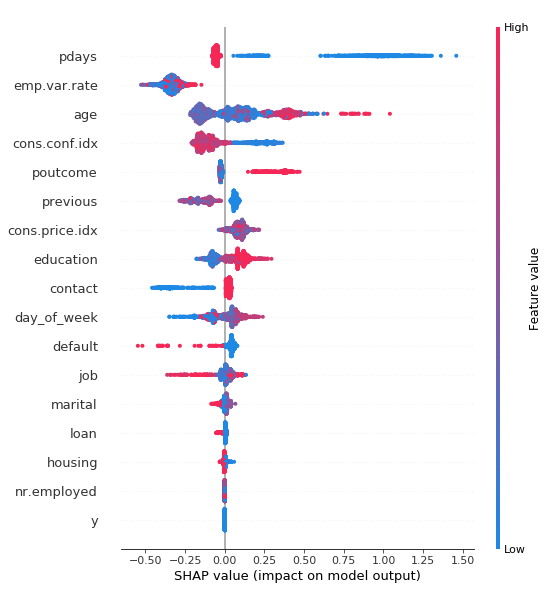

In [363]:
shap.summary_plot(X_val_09_shap, X_val_09)

#### trend analysis

In [385]:
continuous_vars = ['nr.employed', 'emp.var.rate', 'age',  'previous', 'cons.conf.idx',  'cons.price.idx', 'pdays', 'age_c']

In [391]:
trend_stats = get_trend_stats(X_train_09_cp, 'y', features_list=continuous_vars, data_test=X_val_09_cp , bins=5)

Only one bin created for nr.employed. Correlation can't be calculated
Only one bin created for emp.var.rate. Correlation can't be calculated
Only one bin created for cons.price.idx. Correlation can't be calculated
Only one bin created for pdays. Correlation can't be calculated
Returning stats for all numeric features


In [392]:
trend_stats.sort_values('Trend_correlation', ascending=False)

Feature  Trend_changes  Trend_changes_test  Trend_correlation
4   cons.conf.idx              1                   0           1.000000
3        previous              0                   0           0.840366
7           age_c              1                   0           0.520397
0     nr.employed              0                   0           0.000000
1    emp.var.rate              0                   0           0.000000
5  cons.price.idx              1                   0           0.000000
6           pdays              0                   0           0.000000
2             age              1                   2          -0.260782

                                        Plots for nr.employed                                         
Only one bin created for nr.employed. Correlation can't be calculated
                                           Train data plots                                           


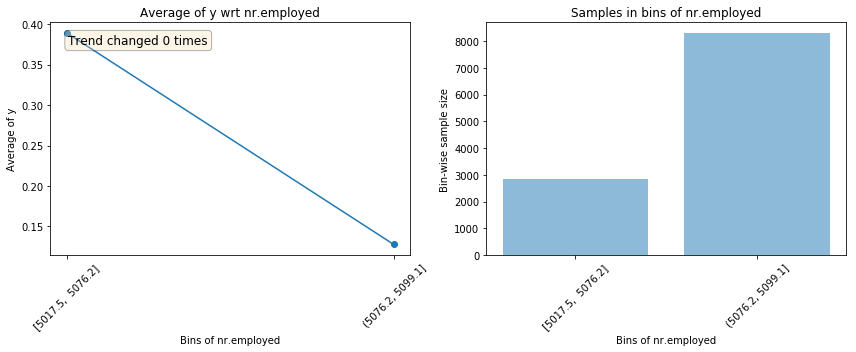

                                           Test data plots                                            


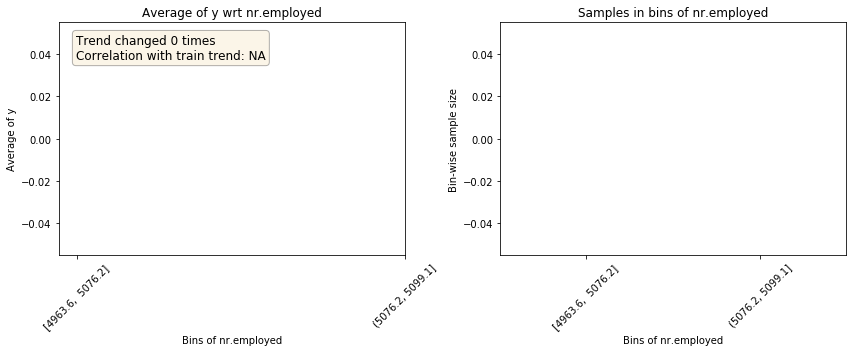

--------------------------------------------------------------------------------------------------------------


                                        Plots for emp.var.rate                                        
Only one bin created for emp.var.rate. Correlation can't be calculated
                                           Train data plots                                           


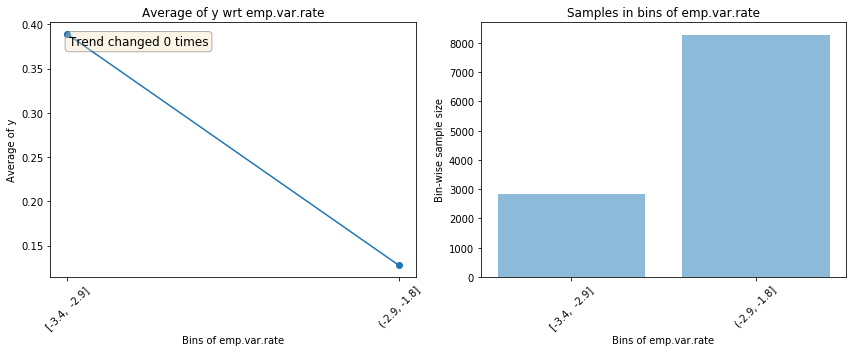

                                           Test data plots                                            


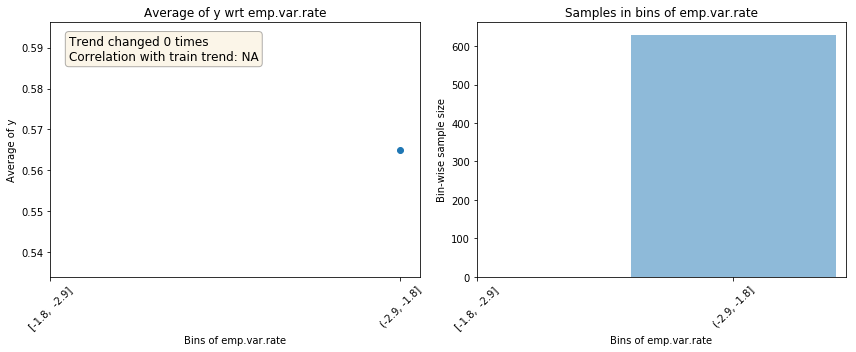

--------------------------------------------------------------------------------------------------------------


                                            Plots for age                                             
                                           Train data plots                                           


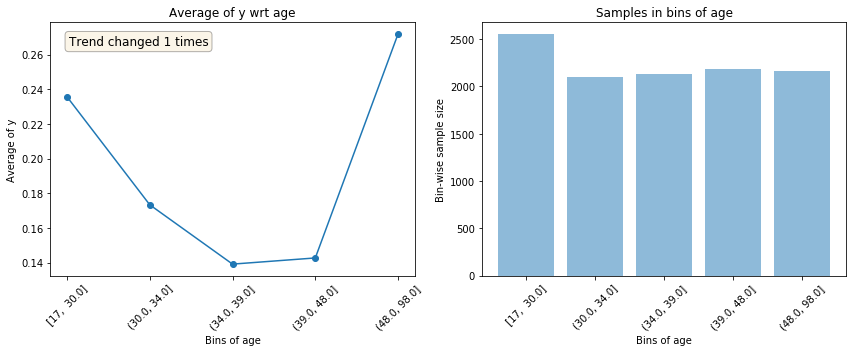

                                           Test data plots                                            


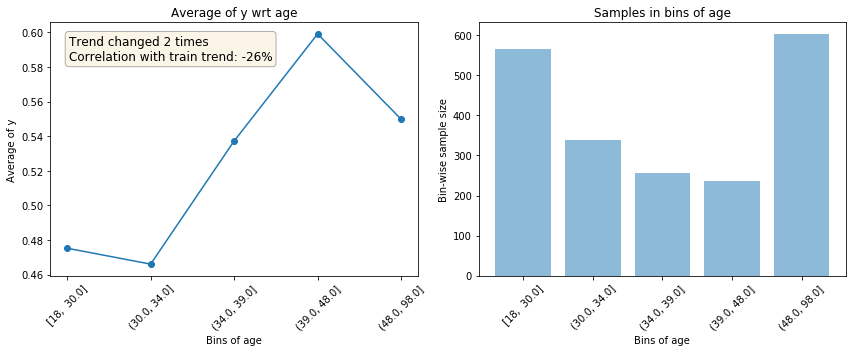

--------------------------------------------------------------------------------------------------------------


                                          Plots for previous                                          
                                           Train data plots                                           


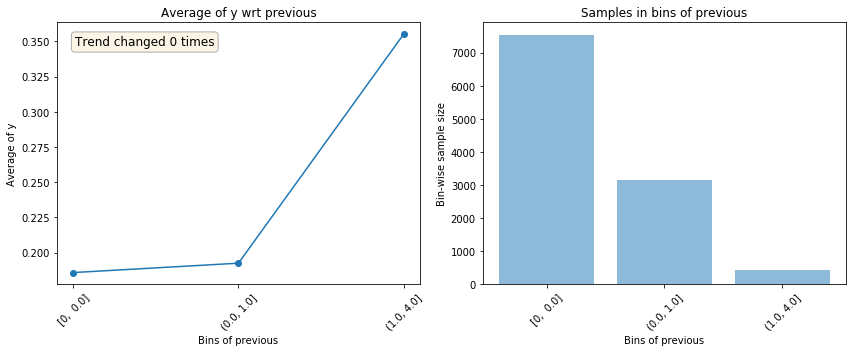

                                           Test data plots                                            


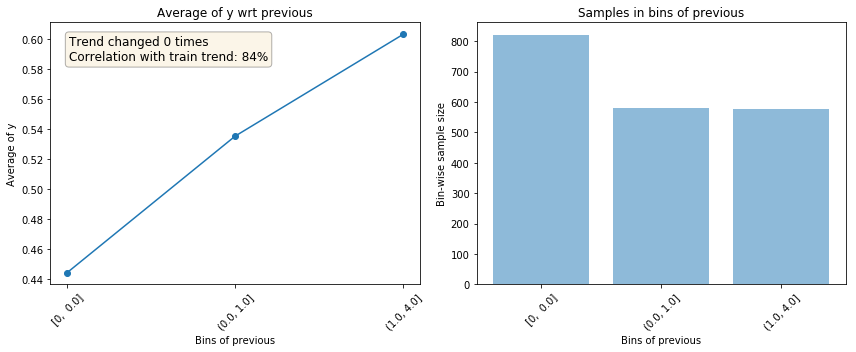

--------------------------------------------------------------------------------------------------------------


                                       Plots for cons.conf.idx                                        
                                           Train data plots                                           


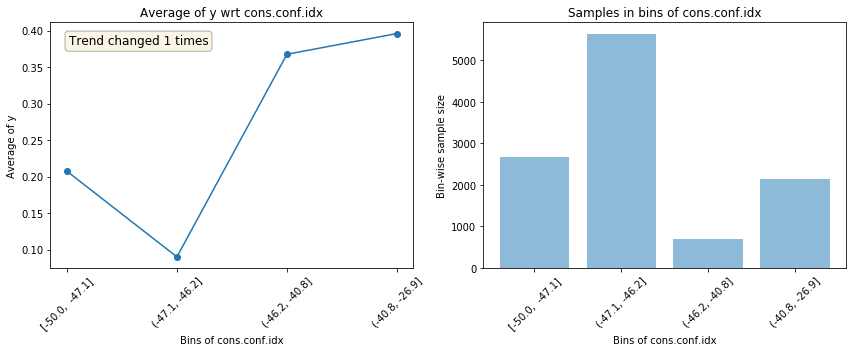

                                           Test data plots                                            


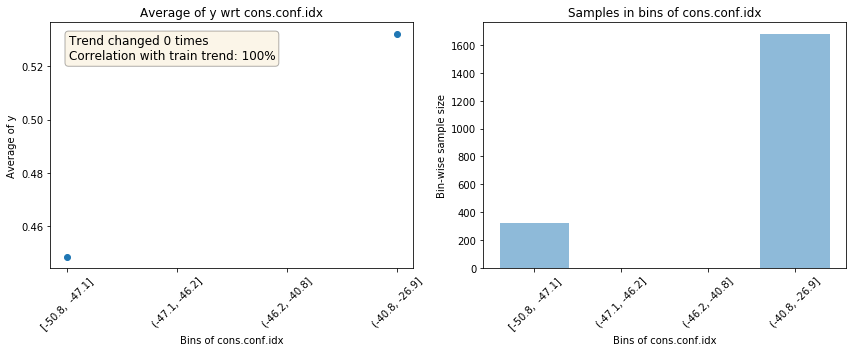

--------------------------------------------------------------------------------------------------------------


                                       Plots for cons.price.idx                                       
Only one bin created for cons.price.idx. Correlation can't be calculated
                                           Train data plots                                           


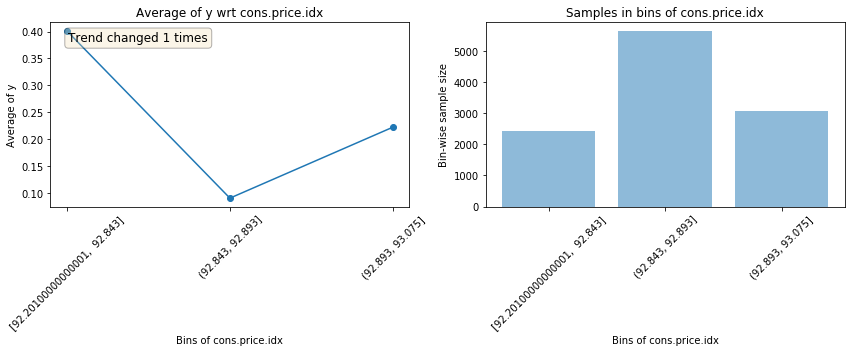

                                           Test data plots                                            


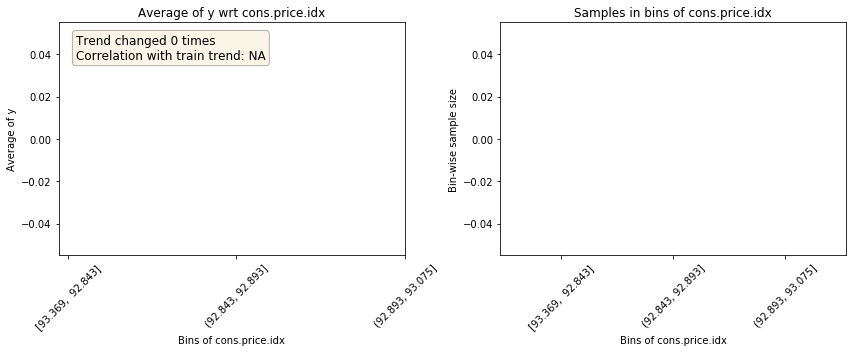

--------------------------------------------------------------------------------------------------------------


                                           Plots for pdays                                            
Only one bin created for pdays. Correlation can't be calculated
                                           Train data plots                                           


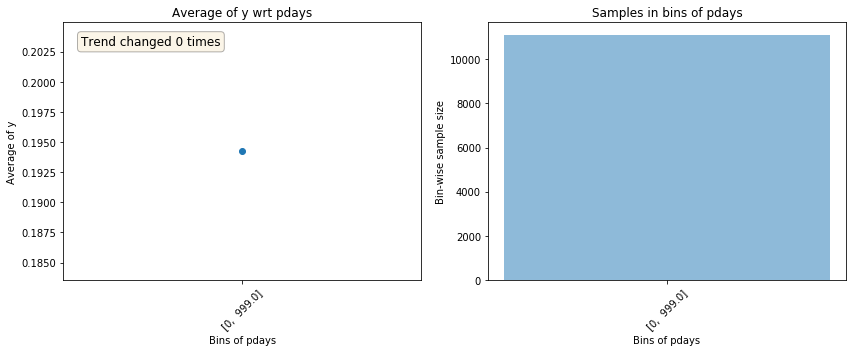

                                           Test data plots                                            


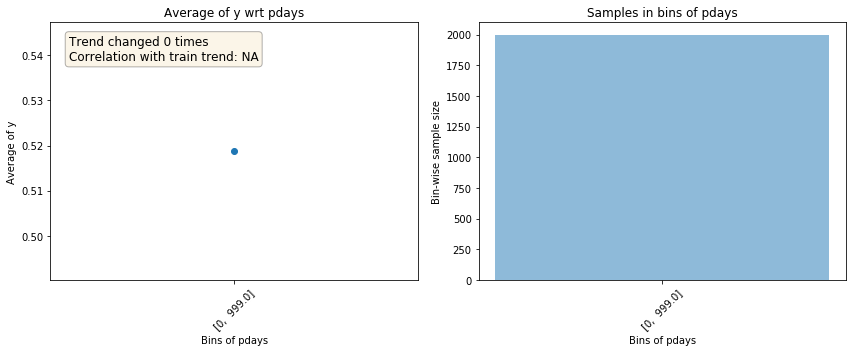

--------------------------------------------------------------------------------------------------------------


                                           Plots for age_c                                            
                                           Train data plots                                           


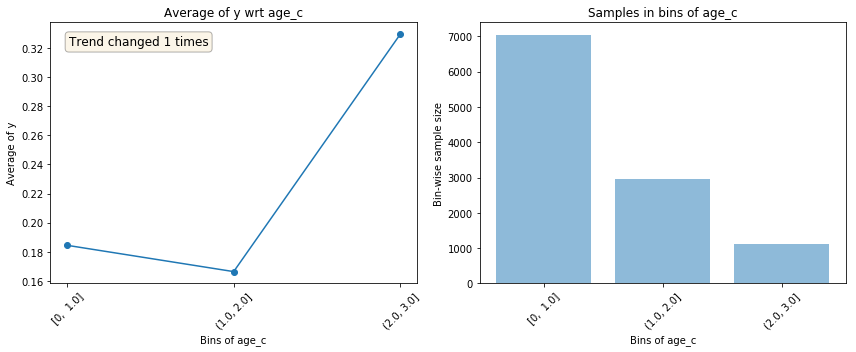

                                           Test data plots                                            


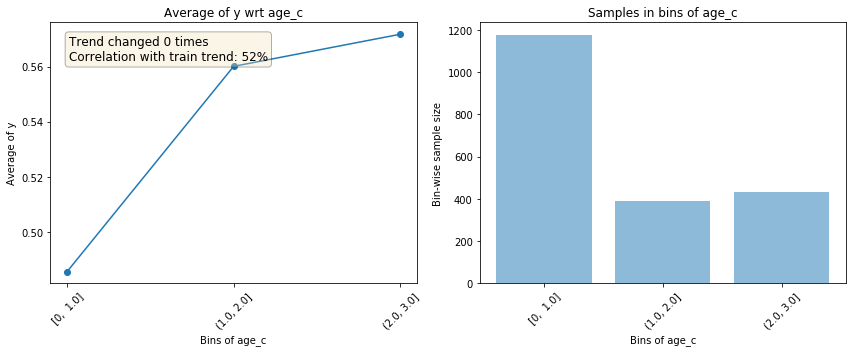

--------------------------------------------------------------------------------------------------------------




In [394]:
get_univariate_plots(X_train_09_cp, 'y', features_list=continuous_vars, data_test=X_val_09_cp , bins=5)

We see that binned variable age_c is more correlated with test, than initial age

In [398]:
to_drop = trend_stats[trend_stats.Trend_correlatxion < .5]

### adversarial

In [396]:
# making a dataset for adversarial CV
# target: 0 is train 1 is test 
# using 70/30 split, stratified by target
X_adv_09 = pd.concat([X_train_09, X_val_09])
y_adv_09 = pd.concat([pd.Series(np.repeat(0, X_train_09.shape[0])), pd.Series(np.repeat(1, X_val_09.shape[0]))])
X_adv_09_train, X_adv_09_val, y_adv_09_train, y_adv_09_val = train_test_split(X_adv_09, y_adv_09, train_size=.7, random_state=9, stratify=y_adv_09, )


features_drop = trend_stats[trend_stats.Trend_correlation < .5]

X_adv_train_1 = X_adv_train_0.drop(features_drop, axis=1,)
X_adv_val_4 = X_adv_val_3.drop(features_drop, axis=1, )

In [400]:
features_drop = trend_stats[trend_stats.Trend_correlation < .5].Feature.tolist()

X_adv_09_train_1 = X_adv_09_train.drop(features_drop, axis=1,)
X_adv_09_val_1 = X_adv_09_val.drop(features_drop, axis=1, )

In [402]:
clf_adv_09_1 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

# fitting xgboost
clf_adv_09_1.fit(X_adv_09_train_1, y_adv_09_train, eval_set=[(X_adv_09_val_1, y_adv_09_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:1
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:1
[20]	validation_0-auc:1
[30]	validation_0-auc:1
Stopping. Best iteration:
[0]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [410]:
pd.Series(clf_adv_09_1.get_booster().get_fscore()).sort_values(ascending=False)

cons.conf.idx    155
dtype: int64

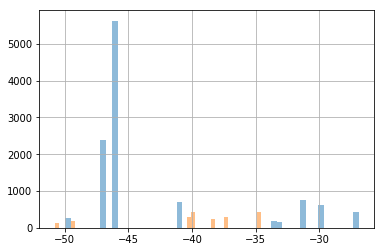

In [415]:
X_train_09['cons.conf.idx'].hist(bins=50, alpha = .5)
X_val_09['cons.conf.idx'].hist(bins=50, alpha=.5)

In [416]:
features_drop = ['cons.conf.idx']

X_adv_09_train_2 = X_adv_09_train_1.drop(features_drop, axis=1,)
X_adv_09_val_2 = X_adv_09_val_1.drop(features_drop, axis=1, )

In [417]:
clf_adv_09_2 = XGBClassifier(n_estimators=10000, max_depth=4, n_jobs= 8, random_state=9 )

# fitting xgboost
clf_adv_09_2.fit(X_adv_09_train_2, y_adv_09_train, eval_set=[(X_adv_09_val_2, y_adv_09_val)], eval_metric='auc', early_stopping_rounds=30, verbose=10)


[0]	validation_0-auc:0.74083
Will train until validation_0-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:0.775651
[20]	validation_0-auc:0.792465
[30]	validation_0-auc:0.801197
[40]	validation_0-auc:0.80753
[50]	validation_0-auc:0.810199
[60]	validation_0-auc:0.810918
[70]	validation_0-auc:0.810684
[80]	validation_0-auc:0.811235
[90]	validation_0-auc:0.812111
[100]	validation_0-auc:0.812136
[110]	validation_0-auc:0.812717
[120]	validation_0-auc:0.812523
[130]	validation_0-auc:0.812164
[140]	validation_0-auc:0.81251
Stopping. Best iteration:
[114]	validation_0-auc:0.812899



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [418]:
pd.Series(clf_adv_09_2.get_booster().get_fscore()).sort_values(ascending=False)

job            351
education      300
age_c          220
day_of_week    196
previous       171
marital        141
contact         93
housing         91
default         77
poutcome        77
loan            61
dtype: int64

In [420]:
shap_val_adv_09_2 = predict_shap_sk(clf_adv_09_2, X_adv_09_val_2)

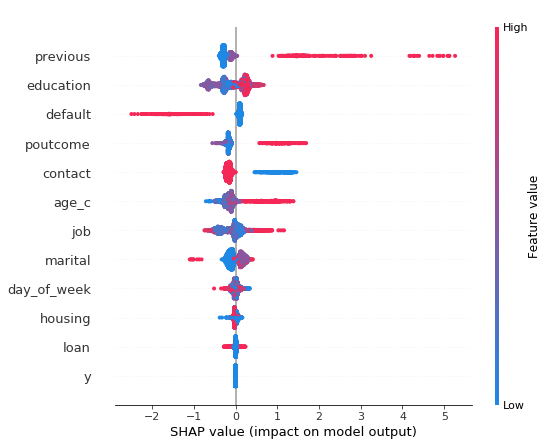

In [422]:
shap.summary_plot(shap_val_adv_09_2, X_adv_09_val_2)